# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import gym
import numpy as np

In [2]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

# Create the Cart-Pole game environment
#env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.00454824 -0.20735203 -0.04576232  0.32077049] 0 1.0 False {}
state, action, reward, done, info: [-0.00869528 -0.01160926 -0.03934691  0.01401429] 1 1.0 False {}
state, action, reward, done, info: [-0.00892746  0.18405424 -0.03906663 -0.2908188 ] 1 1.0 False {}
state, action, reward, done, info: [-0.00524638 -0.01048952 -0.04488301 -0.01070849] 0 1.0 False {}
state, action, reward, done, info: [-0.00545617  0.18524642 -0.04509717 -0.31720789] 1 1.0 False {}
state, action, reward, done, info: [-0.00175124  0.38098072 -0.05144133 -0.62376491] 1 1.0 False {}
state, action, reward, done, info: [ 0.00586837  0.57678172 -0.06391663 -0.93219498] 1 1.0 False {}
state, action, reward, done, info: [ 0.01740401  0.7727052  -0.08256053 -1.24425878] 1 1.0 False {}
state, action, reward, done, info: [ 0.03285811  0.96878368 -0.10744571 -1.56161992] 1 1.0 False {}
state, action, reward, done, info: [ 0.05223378  1.16501446 -0.1386781  -1.88579697] 1 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [6]:
def model_input(state_size, lstm_size, batch_size=1):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    labelQs = tf.placeholder(tf.float32, [None], name='labelQs')
        
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    
    return actions, states, targetQs, labelQs, cell, initial_state

In [7]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [8]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs, labelQs):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    lossQtgt = tf.reduce_mean(tf.square(Qs - targetQs)) # next state, next action and nextQs
    lossQlbl = tf.reduce_mean(tf.square(Qs - labelQs)) # current state, action, and currentQs
    lossQtgt_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs, 
                                                                           labels=tf.nn.sigmoid(targetQs)))
    lossQlbl_sigm = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs,
                                                                           labels=tf.nn.sigmoid(labelQs)))
    loss = lossQtgt + lossQlbl #+ lossQtgt_sigm + lossQlbl_sigm
    return actions_logits, final_state, loss, lossQtgt, lossQlbl, lossQtgt_sigm, lossQlbl_sigm

In [9]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [10]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.actions, self.states, self.targetQs, self.labelQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss, self.lossQtgt, self.lossQlbl, self.lossQtgt_sigm, self.lossQlbl_sigm = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, labelQs=self.labelQs, 
            cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [11]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [12]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [13]:
# Training parameters
# Network parameters
state_size = 4                 # number of units for the input state/observation -- simulation
action_size = 2                # number of units for the output actions -- simulation
hidden_size = 64               # number of units in each Q-network hidden layer -- simulation
batch_size = 32                # number of samples in the memory/ experience as mini-batch size
learning_rate = 0.001          # learning rate for adam

In [14]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [15]:
state = env.reset()
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [16]:
memory.buffer[0]

[array([ 0.01734429,  0.0036899 , -0.0033179 ,  0.00365944]),
 1,
 array([ 0.01741809,  0.19885928, -0.00324471, -0.29006847]),
 1.0,
 0.0]

In [17]:
# states, rewards, actions

In [18]:
# Now train with experiences
saver = tf.train.Saver() # save the trained model
rewards_list, loss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    episode_reward = deque(maxlen=batch_size)
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]

        # Training steps/batches
        while True:
            # Testing
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            actions_logits = sess.run(model.actions_logits, 
                                      feed_dict = {model.states: states, 
                                                   model.initial_state: initial_states[0].reshape([1, -1])})
            labelQs = np.max(actions_logits, axis=1) # explore
            next_actions_logits = sess.run(model.actions_logits, 
                                           feed_dict = {model.states: next_states, 
                                                        model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones) # exploit
            targetQs = rewards + (0.99 * nextQs)
            loss, _, lossQlbl, lossQlbl_sigm, lossQtgt, lossQtgt_sigm = sess.run([model.loss, model.opt, 
                                                                                  model.lossQlbl, 
                                                                                  model.lossQlbl_sigm, 
                                                                                  model.lossQtgt, 
                                                                                  model.lossQtgt_sigm], 
                                            feed_dict = {model.states: states, 
                                                         model.actions: actions,
                                                         model.targetQs: targetQs,
                                                         model.labelQs: labelQs,
                                                         model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode: {}'.format(ep),
              'meanReward: {:.4f}'.format(np.mean(episode_reward)),
              'meanLoss: {:.4f}'.format(np.mean(loss_batch)))
        rewards_list.append([ep, np.mean(episode_reward)])
        loss_list.append([ep, np.mean(loss_batch)])
        if(np.mean(episode_reward) >= 500):
            break
    
    saver.save(sess, 'checkpoints/model5.ckpt')

Episode: 0 meanReward: 79.0000 meanLoss: 2.0324
Episode: 1 meanReward: 60.5000 meanLoss: 3.5357
Episode: 2 meanReward: 52.0000 meanLoss: 6.5075
Episode: 3 meanReward: 49.2500 meanLoss: 6.7281
Episode: 4 meanReward: 44.2000 meanLoss: 11.0835
Episode: 5 meanReward: 39.3333 meanLoss: 18.0686
Episode: 6 meanReward: 37.2857 meanLoss: 18.8232
Episode: 7 meanReward: 39.6250 meanLoss: 8.5163
Episode: 8 meanReward: 39.1111 meanLoss: 16.0877
Episode: 9 meanReward: 38.5000 meanLoss: 16.3416
Episode: 10 meanReward: 37.4545 meanLoss: 16.3686
Episode: 11 meanReward: 36.3333 meanLoss: 15.9999
Episode: 12 meanReward: 35.3846 meanLoss: 6.1176
Episode: 13 meanReward: 34.2143 meanLoss: 5.4468
Episode: 14 meanReward: 32.9333 meanLoss: 4.4587
Episode: 15 meanReward: 31.6250 meanLoss: 2.4320
Episode: 16 meanReward: 30.2941 meanLoss: 12.3756
Episode: 17 meanReward: 29.5000 meanLoss: 13.2213
Episode: 18 meanReward: 29.4211 meanLoss: 2.5846
Episode: 19 meanReward: 28.4000 meanLoss: 1.3671
Episode: 20 meanRewar

Episode: 163 meanReward: 190.1250 meanLoss: 19.7406
Episode: 164 meanReward: 199.2812 meanLoss: 7.0148
Episode: 165 meanReward: 203.8438 meanLoss: 22.8519
Episode: 166 meanReward: 215.9688 meanLoss: 4.7226
Episode: 167 meanReward: 226.9375 meanLoss: 3.1287
Episode: 168 meanReward: 222.7188 meanLoss: 192.2695
Episode: 169 meanReward: 228.7812 meanLoss: 10.2643
Episode: 170 meanReward: 237.4062 meanLoss: 29.7810
Episode: 171 meanReward: 248.0000 meanLoss: 64.6852
Episode: 172 meanReward: 257.4062 meanLoss: 16.4301
Episode: 173 meanReward: 272.3750 meanLoss: 13.1412
Episode: 174 meanReward: 268.1875 meanLoss: 28.8514
Episode: 175 meanReward: 278.9688 meanLoss: 11.6913
Episode: 176 meanReward: 285.6562 meanLoss: 1029.2108
Episode: 177 meanReward: 287.6875 meanLoss: 470.1177
Episode: 178 meanReward: 288.5625 meanLoss: 491.1910
Episode: 179 meanReward: 281.1250 meanLoss: 519.3581
Episode: 180 meanReward: 281.0000 meanLoss: 292.4215
Episode: 181 meanReward: 265.7500 meanLoss: 52.6490
Episode:

Episode: 325 meanReward: 146.4062 meanLoss: 1.8729
Episode: 326 meanReward: 147.1562 meanLoss: 1.8504
Episode: 327 meanReward: 149.2812 meanLoss: 3.3351
Episode: 328 meanReward: 149.9375 meanLoss: 1.9840
Episode: 329 meanReward: 152.0938 meanLoss: 5.0065
Episode: 330 meanReward: 166.3750 meanLoss: 4.7725
Episode: 331 meanReward: 181.1562 meanLoss: 7.6058
Episode: 332 meanReward: 196.0000 meanLoss: 13.8338
Episode: 333 meanReward: 209.8125 meanLoss: 16.9710
Episode: 334 meanReward: 224.6250 meanLoss: 18.2299
Episode: 335 meanReward: 230.7812 meanLoss: 26.3504
Episode: 336 meanReward: 229.6250 meanLoss: 22.3279
Episode: 337 meanReward: 214.9375 meanLoss: 337.4884
Episode: 338 meanReward: 214.9375 meanLoss: 9.4618
Episode: 339 meanReward: 213.7188 meanLoss: 89.6233
Episode: 340 meanReward: 199.8438 meanLoss: 12.6962
Episode: 341 meanReward: 199.2188 meanLoss: 16.6122
Episode: 342 meanReward: 199.2188 meanLoss: 3.3352
Episode: 343 meanReward: 211.5938 meanLoss: 17.0395
Episode: 344 meanRew

Episode: 483 meanReward: 204.3438 meanLoss: 42.5797
Episode: 484 meanReward: 208.7500 meanLoss: 11.0433
Episode: 485 meanReward: 206.8750 meanLoss: 38.7882
Episode: 486 meanReward: 204.5312 meanLoss: 190.6188
Episode: 487 meanReward: 200.9375 meanLoss: 232.6623
Episode: 488 meanReward: 199.3750 meanLoss: 36.3202
Episode: 489 meanReward: 200.6875 meanLoss: 27.4150
Episode: 490 meanReward: 210.1250 meanLoss: 2.2740
Episode: 491 meanReward: 204.2812 meanLoss: 49.5616
Episode: 492 meanReward: 205.3438 meanLoss: 4.6272
Episode: 493 meanReward: 205.3438 meanLoss: 9.3414
Episode: 494 meanReward: 218.5625 meanLoss: 20.5735
Episode: 495 meanReward: 218.5625 meanLoss: 23.8873
Episode: 496 meanReward: 218.9062 meanLoss: 19.7140
Episode: 497 meanReward: 234.1875 meanLoss: 19.1904
Episode: 498 meanReward: 230.2500 meanLoss: 303.4623
Episode: 499 meanReward: 229.9375 meanLoss: 488.0131
Episode: 500 meanReward: 232.4062 meanLoss: 87.7040
Episode: 501 meanReward: 228.5312 meanLoss: 100.9845
Episode: 5

Episode: 642 meanReward: 390.8750 meanLoss: 89.1836
Episode: 643 meanReward: 402.5625 meanLoss: 21.7524
Episode: 644 meanReward: 411.1562 meanLoss: 17.2782
Episode: 645 meanReward: 404.3750 meanLoss: 171.6169
Episode: 646 meanReward: 412.9375 meanLoss: 12.4713
Episode: 647 meanReward: 406.7500 meanLoss: 121.1025
Episode: 648 meanReward: 406.7500 meanLoss: 16.2702
Episode: 649 meanReward: 394.1562 meanLoss: 81.2229
Episode: 650 meanReward: 394.1562 meanLoss: 15.4357
Episode: 651 meanReward: 394.1562 meanLoss: 16.0780
Episode: 652 meanReward: 395.1250 meanLoss: 15.5929
Episode: 653 meanReward: 382.9688 meanLoss: 77.1804
Episode: 654 meanReward: 382.9688 meanLoss: 13.9353
Episode: 655 meanReward: 379.1562 meanLoss: 22.0176
Episode: 656 meanReward: 379.1562 meanLoss: 16.5671
Episode: 657 meanReward: 364.0312 meanLoss: 274.6700
Episode: 658 meanReward: 349.9375 meanLoss: 200.4227
Episode: 659 meanReward: 337.1562 meanLoss: 64.6522
Episode: 660 meanReward: 325.5625 meanLoss: 16.7361
Episode:

Episode: 800 meanReward: 324.9062 meanLoss: 5.2600
Episode: 801 meanReward: 314.1875 meanLoss: 46.7138
Episode: 802 meanReward: 308.3750 meanLoss: 9.9683
Episode: 803 meanReward: 302.0312 meanLoss: 14.8077
Episode: 804 meanReward: 302.0312 meanLoss: 17.2719
Episode: 805 meanReward: 287.2188 meanLoss: 285.1072
Episode: 806 meanReward: 279.5938 meanLoss: 32.7480
Episode: 807 meanReward: 294.1250 meanLoss: 14.9810
Episode: 808 meanReward: 284.9062 meanLoss: 39.6872
Episode: 809 meanReward: 284.9062 meanLoss: 13.7798
Episode: 810 meanReward: 299.9688 meanLoss: 17.1654
Episode: 811 meanReward: 313.7188 meanLoss: 14.6134
Episode: 812 meanReward: 313.7188 meanLoss: 18.4907
Episode: 813 meanReward: 321.4375 meanLoss: 18.4161
Episode: 814 meanReward: 332.7188 meanLoss: 17.7222
Episode: 815 meanReward: 332.7188 meanLoss: 16.5103
Episode: 816 meanReward: 326.4375 meanLoss: 28.7841
Episode: 817 meanReward: 326.4375 meanLoss: 10.2162
Episode: 818 meanReward: 311.5000 meanLoss: 286.5331
Episode: 819

Episode: 958 meanReward: 366.3438 meanLoss: 81.4580
Episode: 959 meanReward: 366.3438 meanLoss: 15.5511
Episode: 960 meanReward: 357.9375 meanLoss: 215.2282
Episode: 961 meanReward: 355.3750 meanLoss: 16.2070
Episode: 962 meanReward: 355.3750 meanLoss: 12.1968
Episode: 963 meanReward: 349.4688 meanLoss: 26.5992
Episode: 964 meanReward: 337.0625 meanLoss: 88.8899
Episode: 965 meanReward: 334.6250 meanLoss: 225.4866
Episode: 966 meanReward: 335.8125 meanLoss: 204.8745
Episode: 967 meanReward: 328.5000 meanLoss: 360.5415
Episode: 968 meanReward: 331.8438 meanLoss: 6.8076
Episode: 969 meanReward: 317.2188 meanLoss: 264.8535
Episode: 970 meanReward: 309.7812 meanLoss: 31.3922
Episode: 971 meanReward: 297.8750 meanLoss: 53.3330
Episode: 972 meanReward: 286.0000 meanLoss: 52.8106
Episode: 973 meanReward: 286.0000 meanLoss: 11.3937
Episode: 974 meanReward: 275.4062 meanLoss: 48.0631
Episode: 975 meanReward: 268.9688 meanLoss: 18.2736
Episode: 976 meanReward: 258.9375 meanLoss: 24.6351
Episode:

Episode: 1114 meanReward: 395.2188 meanLoss: 17.2943
Episode: 1115 meanReward: 408.2812 meanLoss: 13.6745
Episode: 1116 meanReward: 422.3438 meanLoss: 19.0685
Episode: 1117 meanReward: 413.7812 meanLoss: 39.8044
Episode: 1118 meanReward: 417.0938 meanLoss: 16.7132
Episode: 1119 meanReward: 402.0625 meanLoss: 283.2770
Episode: 1120 meanReward: 402.0625 meanLoss: 18.3985
Episode: 1121 meanReward: 402.0625 meanLoss: 16.7030
Episode: 1122 meanReward: 387.2188 meanLoss: 277.1144
Episode: 1123 meanReward: 378.6250 meanLoss: 39.7333
Episode: 1124 meanReward: 378.6250 meanLoss: 9.4778
Episode: 1125 meanReward: 378.6250 meanLoss: 15.6917
Episode: 1126 meanReward: 364.3438 meanLoss: 187.7686
Episode: 1127 meanReward: 379.4062 meanLoss: 14.4938
Episode: 1128 meanReward: 394.5938 meanLoss: 16.0325
Episode: 1129 meanReward: 394.5938 meanLoss: 16.5827
Episode: 1130 meanReward: 386.8750 meanLoss: 33.6071
Episode: 1131 meanReward: 375.7500 meanLoss: 20.0239
Episode: 1132 meanReward: 388.7812 meanLoss:

Episode: 1269 meanReward: 254.1875 meanLoss: 5.0841
Episode: 1270 meanReward: 263.6250 meanLoss: 10.8705
Episode: 1271 meanReward: 278.6562 meanLoss: 14.3161
Episode: 1272 meanReward: 265.8438 meanLoss: 86.4522
Episode: 1273 meanReward: 254.3750 meanLoss: 21.8917
Episode: 1274 meanReward: 254.3750 meanLoss: 5.6106
Episode: 1275 meanReward: 269.3125 meanLoss: 13.9841
Episode: 1276 meanReward: 254.4375 meanLoss: 265.1952
Episode: 1277 meanReward: 245.6562 meanLoss: 32.6037
Episode: 1278 meanReward: 245.6562 meanLoss: 7.3423
Episode: 1279 meanReward: 254.8438 meanLoss: 8.9872
Episode: 1280 meanReward: 254.8438 meanLoss: 5.4223
Episode: 1281 meanReward: 256.1250 meanLoss: 59.0946
Episode: 1282 meanReward: 268.4375 meanLoss: 4.4381
Episode: 1283 meanReward: 281.1250 meanLoss: 16.3946
Episode: 1284 meanReward: 280.7500 meanLoss: 80.7358
Episode: 1285 meanReward: 282.0312 meanLoss: 45.3165
Episode: 1286 meanReward: 282.6562 meanLoss: 58.3696
Episode: 1287 meanReward: 289.5312 meanLoss: 20.264

Episode: 1425 meanReward: 217.4062 meanLoss: 3.8246
Episode: 1426 meanReward: 230.4375 meanLoss: 15.7121
Episode: 1427 meanReward: 243.5312 meanLoss: 16.2227
Episode: 1428 meanReward: 240.9688 meanLoss: 210.4989
Episode: 1429 meanReward: 241.0312 meanLoss: 40.4014
Episode: 1430 meanReward: 253.2812 meanLoss: 1.5963
Episode: 1431 meanReward: 243.5000 meanLoss: 274.9341
Episode: 1432 meanReward: 231.5625 meanLoss: 48.6061
Episode: 1433 meanReward: 231.0312 meanLoss: 7.0919
Episode: 1434 meanReward: 223.0312 meanLoss: 4.6414
Episode: 1435 meanReward: 208.3125 meanLoss: 235.5883
Episode: 1436 meanReward: 193.0625 meanLoss: 121.0975
Episode: 1437 meanReward: 193.0625 meanLoss: 4.7603
Episode: 1438 meanReward: 192.5312 meanLoss: 77.4420
Episode: 1439 meanReward: 205.3125 meanLoss: 12.9125
Episode: 1440 meanReward: 202.9062 meanLoss: 198.8514
Episode: 1441 meanReward: 214.9062 meanLoss: 5.8056
Episode: 1442 meanReward: 227.1250 meanLoss: 14.5258
Episode: 1443 meanReward: 239.5938 meanLoss: 14

Episode: 1580 meanReward: 190.4062 meanLoss: 153.5585
Episode: 1581 meanReward: 177.9688 meanLoss: 70.3376
Episode: 1582 meanReward: 177.0938 meanLoss: 25.3407
Episode: 1583 meanReward: 173.3438 meanLoss: 26.6088
Episode: 1584 meanReward: 173.6250 meanLoss: 20.1553
Episode: 1585 meanReward: 162.7812 meanLoss: 11.9004
Episode: 1586 meanReward: 169.4062 meanLoss: 10.9385
Episode: 1587 meanReward: 178.5625 meanLoss: 8.3067
Episode: 1588 meanReward: 185.0312 meanLoss: 12.2574
Episode: 1589 meanReward: 186.1250 meanLoss: 31.7565
Episode: 1590 meanReward: 186.5625 meanLoss: 44.6209
Episode: 1591 meanReward: 187.4375 meanLoss: 16.2068
Episode: 1592 meanReward: 183.7812 meanLoss: 20.4867
Episode: 1593 meanReward: 191.6562 meanLoss: 10.7888
Episode: 1594 meanReward: 187.3750 meanLoss: 23.9902
Episode: 1595 meanReward: 186.7500 meanLoss: 10.4233
Episode: 1596 meanReward: 184.7188 meanLoss: 46.6044
Episode: 1597 meanReward: 183.2812 meanLoss: 36.3313
Episode: 1598 meanReward: 181.3750 meanLoss: 3

Episode: 1735 meanReward: 193.2188 meanLoss: 6.9768
Episode: 1736 meanReward: 184.9688 meanLoss: 6.0119
Episode: 1737 meanReward: 173.9375 meanLoss: 14.5451
Episode: 1738 meanReward: 174.5938 meanLoss: 11.2700
Episode: 1739 meanReward: 186.0938 meanLoss: 3.6357
Episode: 1740 meanReward: 187.8750 meanLoss: 37.1042
Episode: 1741 meanReward: 196.7812 meanLoss: 10.7140
Episode: 1742 meanReward: 196.7812 meanLoss: 13.9952
Episode: 1743 meanReward: 206.2188 meanLoss: 11.3224
Episode: 1744 meanReward: 206.2188 meanLoss: 16.4031
Episode: 1745 meanReward: 218.3438 meanLoss: 19.7709
Episode: 1746 meanReward: 218.3438 meanLoss: 14.4296
Episode: 1747 meanReward: 227.4688 meanLoss: 17.0076
Episode: 1748 meanReward: 227.5625 meanLoss: 61.2501
Episode: 1749 meanReward: 224.5938 meanLoss: 50.1304
Episode: 1750 meanReward: 224.3438 meanLoss: 20.9217
Episode: 1751 meanReward: 225.2188 meanLoss: 31.9144
Episode: 1752 meanReward: 235.1562 meanLoss: 11.7651
Episode: 1753 meanReward: 250.3438 meanLoss: 7.80

Episode: 1891 meanReward: 187.0312 meanLoss: 13.5691
Episode: 1892 meanReward: 187.5312 meanLoss: 42.5532
Episode: 1893 meanReward: 194.3750 meanLoss: 4.8780
Episode: 1894 meanReward: 198.1875 meanLoss: 28.7865
Episode: 1895 meanReward: 201.5625 meanLoss: 35.0245
Episode: 1896 meanReward: 202.0625 meanLoss: 74.1236
Episode: 1897 meanReward: 204.3750 meanLoss: 38.8952
Episode: 1898 meanReward: 205.3125 meanLoss: 42.6050
Episode: 1899 meanReward: 195.2500 meanLoss: 30.6964
Episode: 1900 meanReward: 195.1250 meanLoss: 45.1575
Episode: 1901 meanReward: 195.6562 meanLoss: 39.7917
Episode: 1902 meanReward: 196.4375 meanLoss: 28.8883
Episode: 1903 meanReward: 195.9062 meanLoss: 52.7388
Episode: 1904 meanReward: 184.8438 meanLoss: 27.0414
Episode: 1905 meanReward: 183.6562 meanLoss: 46.1681
Episode: 1906 meanReward: 185.4062 meanLoss: 8.8565
Episode: 1907 meanReward: 187.2812 meanLoss: 23.3042
Episode: 1908 meanReward: 173.8438 meanLoss: 49.3084
Episode: 1909 meanReward: 174.3125 meanLoss: 5.9

Episode: 2047 meanReward: 183.6562 meanLoss: 2.3625
Episode: 2048 meanReward: 183.6562 meanLoss: 17.9692
Episode: 2049 meanReward: 183.6562 meanLoss: 17.0140
Episode: 2050 meanReward: 194.8125 meanLoss: 16.1691
Episode: 2051 meanReward: 194.8125 meanLoss: 16.2668
Episode: 2052 meanReward: 210.0000 meanLoss: 16.6254
Episode: 2053 meanReward: 221.5938 meanLoss: 16.7174
Episode: 2054 meanReward: 231.4375 meanLoss: 16.7599
Episode: 2055 meanReward: 244.7188 meanLoss: 16.8635
Episode: 2056 meanReward: 257.8438 meanLoss: 16.8716
Episode: 2057 meanReward: 271.3750 meanLoss: 16.9566
Episode: 2058 meanReward: 280.0312 meanLoss: 27.1295
Episode: 2059 meanReward: 282.0938 meanLoss: 6.7837
Episode: 2060 meanReward: 283.0000 meanLoss: 10.0624
Episode: 2061 meanReward: 297.7500 meanLoss: 50.5769
Episode: 2062 meanReward: 309.7500 meanLoss: 18.4068
Episode: 2063 meanReward: 321.5312 meanLoss: 17.0530
Episode: 2064 meanReward: 333.2812 meanLoss: 17.8717
Episode: 2065 meanReward: 344.9375 meanLoss: 16.

Episode: 2202 meanReward: 388.1875 meanLoss: 20.1326
Episode: 2203 meanReward: 387.0938 meanLoss: 32.1403
Episode: 2204 meanReward: 388.3750 meanLoss: 43.2061
Episode: 2205 meanReward: 379.1562 meanLoss: 26.5475
Episode: 2206 meanReward: 370.2812 meanLoss: 26.4112
Episode: 2207 meanReward: 360.8750 meanLoss: 28.0843
Episode: 2208 meanReward: 350.4688 meanLoss: 33.4023
Episode: 2209 meanReward: 340.4375 meanLoss: 29.7630
Episode: 2210 meanReward: 327.8125 meanLoss: 56.3715
Episode: 2211 meanReward: 315.2188 meanLoss: 49.1352
Episode: 2212 meanReward: 300.9688 meanLoss: 90.7142
Episode: 2213 meanReward: 287.5312 meanLoss: 61.1102
Episode: 2214 meanReward: 273.7500 meanLoss: 48.5004
Episode: 2215 meanReward: 275.7812 meanLoss: 26.0709
Episode: 2216 meanReward: 265.1250 meanLoss: 20.7912
Episode: 2217 meanReward: 254.9375 meanLoss: 22.5286
Episode: 2218 meanReward: 243.0312 meanLoss: 31.9539
Episode: 2219 meanReward: 229.2500 meanLoss: 62.5369
Episode: 2220 meanReward: 216.7812 meanLoss: 2

Episode: 2357 meanReward: 113.2188 meanLoss: 23.2705
Episode: 2358 meanReward: 115.8438 meanLoss: 10.1986
Episode: 2359 meanReward: 119.7500 meanLoss: 8.0408
Episode: 2360 meanReward: 123.2812 meanLoss: 11.2890
Episode: 2361 meanReward: 126.7188 meanLoss: 6.7917
Episode: 2362 meanReward: 129.5938 meanLoss: 17.4563
Episode: 2363 meanReward: 133.1250 meanLoss: 10.9525
Episode: 2364 meanReward: 134.8438 meanLoss: 20.3960
Episode: 2365 meanReward: 137.7500 meanLoss: 21.3289
Episode: 2366 meanReward: 137.6250 meanLoss: 24.5996
Episode: 2367 meanReward: 135.3438 meanLoss: 63.5067
Episode: 2368 meanReward: 133.9375 meanLoss: 27.9665
Episode: 2369 meanReward: 130.0625 meanLoss: 22.7120
Episode: 2370 meanReward: 122.6250 meanLoss: 27.4605
Episode: 2371 meanReward: 120.0312 meanLoss: 13.9268
Episode: 2372 meanReward: 121.7500 meanLoss: 21.6070
Episode: 2373 meanReward: 126.3438 meanLoss: 21.0666
Episode: 2374 meanReward: 125.8438 meanLoss: 129.8613
Episode: 2375 meanReward: 124.8750 meanLoss: 25

Episode: 2512 meanReward: 193.4688 meanLoss: 15.3229
Episode: 2513 meanReward: 192.8750 meanLoss: 28.3714
Episode: 2514 meanReward: 191.2500 meanLoss: 23.1122
Episode: 2515 meanReward: 189.5312 meanLoss: 21.8797
Episode: 2516 meanReward: 184.1250 meanLoss: 20.4017
Episode: 2517 meanReward: 170.9062 meanLoss: 21.1838
Episode: 2518 meanReward: 165.9062 meanLoss: 15.8696
Episode: 2519 meanReward: 153.4688 meanLoss: 22.3817
Episode: 2520 meanReward: 153.4688 meanLoss: 32.0434
Episode: 2521 meanReward: 154.9062 meanLoss: 28.7748
Episode: 2522 meanReward: 154.0625 meanLoss: 39.8100
Episode: 2523 meanReward: 151.5312 meanLoss: 31.7811
Episode: 2524 meanReward: 153.0312 meanLoss: 18.0096
Episode: 2525 meanReward: 141.6562 meanLoss: 25.9899
Episode: 2526 meanReward: 141.2812 meanLoss: 41.0915
Episode: 2527 meanReward: 139.1875 meanLoss: 41.1534
Episode: 2528 meanReward: 135.2188 meanLoss: 36.0166
Episode: 2529 meanReward: 137.8438 meanLoss: 35.0372
Episode: 2530 meanReward: 137.0938 meanLoss: 3

Episode: 2668 meanReward: 204.7812 meanLoss: 8.1764
Episode: 2669 meanReward: 204.9375 meanLoss: 14.7739
Episode: 2670 meanReward: 206.0938 meanLoss: 9.4544
Episode: 2671 meanReward: 208.1250 meanLoss: 10.9138
Episode: 2672 meanReward: 210.4688 meanLoss: 7.6809
Episode: 2673 meanReward: 207.5938 meanLoss: 11.7008
Episode: 2674 meanReward: 210.3750 meanLoss: 4.5661
Episode: 2675 meanReward: 211.2812 meanLoss: 4.8714
Episode: 2676 meanReward: 207.0312 meanLoss: 33.0911
Episode: 2677 meanReward: 214.2812 meanLoss: 7.1475
Episode: 2678 meanReward: 207.1562 meanLoss: 27.9545
Episode: 2679 meanReward: 217.2500 meanLoss: 4.6286
Episode: 2680 meanReward: 215.9375 meanLoss: 35.2148
Episode: 2681 meanReward: 221.3438 meanLoss: 4.3360
Episode: 2682 meanReward: 231.7500 meanLoss: 31.0138
Episode: 2683 meanReward: 233.9062 meanLoss: 35.8654
Episode: 2684 meanReward: 224.4375 meanLoss: 23.4996
Episode: 2685 meanReward: 233.9375 meanLoss: 6.8032
Episode: 2686 meanReward: 225.6250 meanLoss: 38.4722
Ep

Episode: 2824 meanReward: 211.3438 meanLoss: 60.6432
Episode: 2825 meanReward: 212.7812 meanLoss: 10.6300
Episode: 2826 meanReward: 222.2188 meanLoss: 5.5660
Episode: 2827 meanReward: 233.9062 meanLoss: 12.2813
Episode: 2828 meanReward: 233.5625 meanLoss: 78.6891
Episode: 2829 meanReward: 245.1875 meanLoss: 5.1908
Episode: 2830 meanReward: 256.8438 meanLoss: 19.3067
Episode: 2831 meanReward: 267.6562 meanLoss: 18.0159
Episode: 2832 meanReward: 278.7812 meanLoss: 15.4575
Episode: 2833 meanReward: 278.0000 meanLoss: 73.4052
Episode: 2834 meanReward: 272.0938 meanLoss: 12.4700
Episode: 2835 meanReward: 264.0000 meanLoss: 31.2083
Episode: 2836 meanReward: 275.8125 meanLoss: 1.8776
Episode: 2837 meanReward: 276.8125 meanLoss: 54.4582
Episode: 2838 meanReward: 278.1250 meanLoss: 4.9116
Episode: 2839 meanReward: 280.9062 meanLoss: 8.4498
Episode: 2840 meanReward: 271.4375 meanLoss: 4.7977
Episode: 2841 meanReward: 282.5938 meanLoss: 2.8836
Episode: 2842 meanReward: 278.5938 meanLoss: 172.6445

Episode: 2979 meanReward: 281.9375 meanLoss: 2.1100
Episode: 2980 meanReward: 269.5312 meanLoss: 85.7649
Episode: 2981 meanReward: 271.5938 meanLoss: 3.4609
Episode: 2982 meanReward: 261.5625 meanLoss: 48.6224
Episode: 2983 meanReward: 261.5625 meanLoss: 7.6091
Episode: 2984 meanReward: 264.0312 meanLoss: 41.7267
Episode: 2985 meanReward: 265.9375 meanLoss: 53.5202
Episode: 2986 meanReward: 269.5000 meanLoss: 42.2737
Episode: 2987 meanReward: 272.6875 meanLoss: 41.1093
Episode: 2988 meanReward: 269.5625 meanLoss: 115.9381
Episode: 2989 meanReward: 254.4688 meanLoss: 216.4578
Episode: 2990 meanReward: 253.2812 meanLoss: 39.4125
Episode: 2991 meanReward: 259.0000 meanLoss: 9.5518
Episode: 2992 meanReward: 269.1562 meanLoss: 15.9645
Episode: 2993 meanReward: 272.8438 meanLoss: 15.5997
Episode: 2994 meanReward: 271.2500 meanLoss: 77.0229
Episode: 2995 meanReward: 277.9375 meanLoss: 15.4681
Episode: 2996 meanReward: 276.3750 meanLoss: 23.7234
Episode: 2997 meanReward: 266.9062 meanLoss: 41.

Episode: 3134 meanReward: 226.8438 meanLoss: 18.9356
Episode: 3135 meanReward: 237.1875 meanLoss: 19.1313
Episode: 3136 meanReward: 246.0625 meanLoss: 17.3700
Episode: 3137 meanReward: 258.7188 meanLoss: 12.1936
Episode: 3138 meanReward: 269.1875 meanLoss: 16.8562
Episode: 3139 meanReward: 271.3438 meanLoss: 40.3303
Episode: 3140 meanReward: 284.0938 meanLoss: 12.6533
Episode: 3141 meanReward: 278.4375 meanLoss: 271.8486
Episode: 3142 meanReward: 274.7500 meanLoss: 493.2088
Episode: 3143 meanReward: 272.7500 meanLoss: 464.7007
Episode: 3144 meanReward: 268.2500 meanLoss: 419.5294
Episode: 3145 meanReward: 267.6875 meanLoss: 371.0940
Episode: 3146 meanReward: 265.0625 meanLoss: 369.7375
Episode: 3147 meanReward: 261.0000 meanLoss: 315.7104
Episode: 3148 meanReward: 261.0000 meanLoss: 282.8326
Episode: 3149 meanReward: 260.9688 meanLoss: 250.1951
Episode: 3150 meanReward: 261.0000 meanLoss: 186.2642
Episode: 3151 meanReward: 261.2500 meanLoss: 67.7835
Episode: 3152 meanReward: 276.5938 m

Episode: 3289 meanReward: 114.5625 meanLoss: 19.6393
Episode: 3290 meanReward: 111.5938 meanLoss: 166.9154
Episode: 3291 meanReward: 108.6875 meanLoss: 309.1516
Episode: 3292 meanReward: 105.6875 meanLoss: 287.4141
Episode: 3293 meanReward: 102.9375 meanLoss: 248.6732
Episode: 3294 meanReward: 100.2500 meanLoss: 215.3649
Episode: 3295 meanReward: 96.8125 meanLoss: 138.9401
Episode: 3296 meanReward: 93.9375 meanLoss: 249.1378
Episode: 3297 meanReward: 96.5938 meanLoss: 44.9232
Episode: 3298 meanReward: 97.9688 meanLoss: 16.1720
Episode: 3299 meanReward: 93.6562 meanLoss: 16.3223
Episode: 3300 meanReward: 91.5312 meanLoss: 47.2477
Episode: 3301 meanReward: 89.9062 meanLoss: 21.3792
Episode: 3302 meanReward: 91.1562 meanLoss: 16.9639
Episode: 3303 meanReward: 90.5000 meanLoss: 15.2865
Episode: 3304 meanReward: 82.5000 meanLoss: 11.9948
Episode: 3305 meanReward: 81.7188 meanLoss: 14.9724
Episode: 3306 meanReward: 85.2812 meanLoss: 15.2308
Episode: 3307 meanReward: 87.2188 meanLoss: 20.2001

Episode: 3445 meanReward: 248.9688 meanLoss: 35.5452
Episode: 3446 meanReward: 239.4688 meanLoss: 201.2407
Episode: 3447 meanReward: 228.7812 meanLoss: 286.3106
Episode: 3448 meanReward: 223.2188 meanLoss: 244.2762
Episode: 3449 meanReward: 233.7500 meanLoss: 7.3908
Episode: 3450 meanReward: 241.5625 meanLoss: 22.8815
Episode: 3451 meanReward: 246.6250 meanLoss: 24.9395
Episode: 3452 meanReward: 240.3438 meanLoss: 55.4637
Episode: 3453 meanReward: 234.9688 meanLoss: 17.3730
Episode: 3454 meanReward: 228.9688 meanLoss: 226.1030
Episode: 3455 meanReward: 222.4062 meanLoss: 381.8794
Episode: 3456 meanReward: 207.0625 meanLoss: 361.0234
Episode: 3457 meanReward: 206.9062 meanLoss: 249.6901
Episode: 3458 meanReward: 211.3750 meanLoss: 27.3450
Episode: 3459 meanReward: 215.6875 meanLoss: 47.4611
Episode: 3460 meanReward: 221.3125 meanLoss: 32.5512
Episode: 3461 meanReward: 216.0312 meanLoss: 41.8769
Episode: 3462 meanReward: 217.4062 meanLoss: 26.2565
Episode: 3463 meanReward: 222.8438 meanL

Episode: 3600 meanReward: 289.0625 meanLoss: 29.6448
Episode: 3601 meanReward: 274.1875 meanLoss: 199.4534
Episode: 3602 meanReward: 258.9062 meanLoss: 271.0576
Episode: 3603 meanReward: 243.7188 meanLoss: 179.8761
Episode: 3604 meanReward: 245.3438 meanLoss: 9.5713
Episode: 3605 meanReward: 250.7500 meanLoss: 3.0269
Episode: 3606 meanReward: 246.2188 meanLoss: 59.6145
Episode: 3607 meanReward: 239.4375 meanLoss: 16.6076
Episode: 3608 meanReward: 239.8750 meanLoss: 21.9108
Episode: 3609 meanReward: 231.7500 meanLoss: 52.3623
Episode: 3610 meanReward: 233.0312 meanLoss: 3.5717
Episode: 3611 meanReward: 225.2500 meanLoss: 34.9943
Episode: 3612 meanReward: 214.4688 meanLoss: 25.7595
Episode: 3613 meanReward: 215.4062 meanLoss: 21.1136
Episode: 3614 meanReward: 218.4375 meanLoss: 13.9209
Episode: 3615 meanReward: 220.4375 meanLoss: 17.1164
Episode: 3616 meanReward: 212.2500 meanLoss: 14.7077
Episode: 3617 meanReward: 212.2500 meanLoss: 8.1123
Episode: 3618 meanReward: 218.8125 meanLoss: 21

Episode: 3755 meanReward: 235.8438 meanLoss: 208.6629
Episode: 3756 meanReward: 220.6250 meanLoss: 254.9206
Episode: 3757 meanReward: 220.3438 meanLoss: 259.9486
Episode: 3758 meanReward: 220.2500 meanLoss: 188.9284
Episode: 3759 meanReward: 235.4375 meanLoss: 10.8019
Episode: 3760 meanReward: 235.4375 meanLoss: 12.2466
Episode: 3761 meanReward: 246.6250 meanLoss: 14.5222
Episode: 3762 meanReward: 244.8750 meanLoss: 44.8710
Episode: 3763 meanReward: 235.5000 meanLoss: 32.9838
Episode: 3764 meanReward: 250.0312 meanLoss: 12.0077
Episode: 3765 meanReward: 261.3750 meanLoss: 18.6351
Episode: 3766 meanReward: 276.5938 meanLoss: 13.5984
Episode: 3767 meanReward: 291.8438 meanLoss: 15.2343
Episode: 3768 meanReward: 302.8125 meanLoss: 16.1217
Episode: 3769 meanReward: 314.7812 meanLoss: 18.5227
Episode: 3770 meanReward: 312.8438 meanLoss: 194.3671
Episode: 3771 meanReward: 302.6562 meanLoss: 25.6923
Episode: 3772 meanReward: 293.9688 meanLoss: 30.8802
Episode: 3773 meanReward: 285.3125 meanLo

Episode: 3910 meanReward: 116.1875 meanLoss: 14.4754
Episode: 3911 meanReward: 116.7500 meanLoss: 12.1586
Episode: 3912 meanReward: 119.8125 meanLoss: 9.6377
Episode: 3913 meanReward: 122.0312 meanLoss: 19.6642
Episode: 3914 meanReward: 122.6562 meanLoss: 15.7827
Episode: 3915 meanReward: 124.9375 meanLoss: 5.8034
Episode: 3916 meanReward: 127.2812 meanLoss: 8.4560
Episode: 3917 meanReward: 131.1562 meanLoss: 27.3439
Episode: 3918 meanReward: 137.8125 meanLoss: 3.6667
Episode: 3919 meanReward: 135.1250 meanLoss: 197.9229
Episode: 3920 meanReward: 136.8438 meanLoss: 36.2840
Episode: 3921 meanReward: 140.5312 meanLoss: 21.1434
Episode: 3922 meanReward: 147.3125 meanLoss: 6.9652
Episode: 3923 meanReward: 144.8125 meanLoss: 159.8759
Episode: 3924 meanReward: 144.2812 meanLoss: 49.8884
Episode: 3925 meanReward: 149.1875 meanLoss: 9.2546
Episode: 3926 meanReward: 153.9375 meanLoss: 7.5423
Episode: 3927 meanReward: 155.1875 meanLoss: 20.3784
Episode: 3928 meanReward: 160.4688 meanLoss: 18.261

Episode: 4066 meanReward: 162.0000 meanLoss: 65.9250
Episode: 4067 meanReward: 164.7188 meanLoss: 20.6391
Episode: 4068 meanReward: 179.9062 meanLoss: 7.3827
Episode: 4069 meanReward: 192.4688 meanLoss: 20.2915
Episode: 4070 meanReward: 205.2188 meanLoss: 19.7258
Episode: 4071 meanReward: 217.0938 meanLoss: 18.8997
Episode: 4072 meanReward: 228.7812 meanLoss: 18.1585
Episode: 4073 meanReward: 240.3438 meanLoss: 18.4861
Episode: 4074 meanReward: 240.3750 meanLoss: 62.8304
Episode: 4075 meanReward: 240.2812 meanLoss: 69.4800
Episode: 4076 meanReward: 252.5312 meanLoss: 13.4247
Episode: 4077 meanReward: 264.6875 meanLoss: 14.0315
Episode: 4078 meanReward: 272.6875 meanLoss: 20.9584
Episode: 4079 meanReward: 272.0000 meanLoss: 68.8417
Episode: 4080 meanReward: 283.4375 meanLoss: 6.3302
Episode: 4081 meanReward: 284.2812 meanLoss: 35.2852
Episode: 4082 meanReward: 285.0938 meanLoss: 52.2340
Episode: 4083 meanReward: 285.8125 meanLoss: 36.4005
Episode: 4084 meanReward: 286.9688 meanLoss: 45.

Episode: 4221 meanReward: 275.4062 meanLoss: 49.8177
Episode: 4222 meanReward: 260.1250 meanLoss: 135.8384
Episode: 4223 meanReward: 244.8125 meanLoss: 202.0018
Episode: 4224 meanReward: 244.8125 meanLoss: 13.1263
Episode: 4225 meanReward: 253.2188 meanLoss: 14.7143
Episode: 4226 meanReward: 253.2188 meanLoss: 15.1055
Episode: 4227 meanReward: 264.8438 meanLoss: 15.4669
Episode: 4228 meanReward: 280.0938 meanLoss: 15.5906
Episode: 4229 meanReward: 295.2812 meanLoss: 15.6881
Episode: 4230 meanReward: 295.2812 meanLoss: 15.8276
Episode: 4231 meanReward: 305.6250 meanLoss: 15.4008
Episode: 4232 meanReward: 316.5625 meanLoss: 16.2607
Episode: 4233 meanReward: 312.3438 meanLoss: 206.8521
Episode: 4234 meanReward: 300.1562 meanLoss: 66.6901
Episode: 4235 meanReward: 300.1562 meanLoss: 1.2688
Episode: 4236 meanReward: 298.9375 meanLoss: 78.5721
Episode: 4237 meanReward: 298.0938 meanLoss: 53.2977
Episode: 4238 meanReward: 285.8125 meanLoss: 24.4664
Episode: 4239 meanReward: 288.0312 meanLoss:

Episode: 4377 meanReward: 288.6562 meanLoss: 100.7072
Episode: 4378 meanReward: 285.0625 meanLoss: 19.5134
Episode: 4379 meanReward: 273.0312 meanLoss: 18.3173
Episode: 4380 meanReward: 268.4688 meanLoss: 17.8341
Episode: 4381 meanReward: 263.4375 meanLoss: 316.5970
Episode: 4382 meanReward: 248.1562 meanLoss: 415.6582
Episode: 4383 meanReward: 245.6875 meanLoss: 378.1340
Episode: 4384 meanReward: 233.5312 meanLoss: 88.9644
Episode: 4385 meanReward: 233.7812 meanLoss: 24.1430
Episode: 4386 meanReward: 223.2188 meanLoss: 20.3365
Episode: 4387 meanReward: 221.3125 meanLoss: 45.7954
Episode: 4388 meanReward: 211.6562 meanLoss: 37.5869
Episode: 4389 meanReward: 212.0625 meanLoss: 55.7842
Episode: 4390 meanReward: 209.8438 meanLoss: 34.6544
Episode: 4391 meanReward: 208.1250 meanLoss: 57.7206
Episode: 4392 meanReward: 197.8438 meanLoss: 40.2898
Episode: 4393 meanReward: 188.1875 meanLoss: 10.3479
Episode: 4394 meanReward: 185.3438 meanLoss: 78.8154
Episode: 4395 meanReward: 175.0312 meanLos

Episode: 4532 meanReward: 305.9062 meanLoss: 64.9506
Episode: 4533 meanReward: 309.0000 meanLoss: 16.4706
Episode: 4534 meanReward: 309.0000 meanLoss: 6.0517
Episode: 4535 meanReward: 314.9688 meanLoss: 18.5995
Episode: 4536 meanReward: 326.9688 meanLoss: 8.4589
Episode: 4537 meanReward: 320.6562 meanLoss: 28.8818
Episode: 4538 meanReward: 320.6562 meanLoss: 12.8900
Episode: 4539 meanReward: 325.8750 meanLoss: 18.8290
Episode: 4540 meanReward: 331.3750 meanLoss: 7.8597
Episode: 4541 meanReward: 329.1250 meanLoss: 11.8743
Episode: 4542 meanReward: 333.1562 meanLoss: 5.8481
Episode: 4543 meanReward: 328.6875 meanLoss: 45.9737
Episode: 4544 meanReward: 340.5312 meanLoss: 10.6826
Episode: 4545 meanReward: 355.8125 meanLoss: 16.2996
Episode: 4546 meanReward: 371.0625 meanLoss: 15.4550
Episode: 4547 meanReward: 378.5625 meanLoss: 31.9242
Episode: 4548 meanReward: 377.9062 meanLoss: 7.6324
Episode: 4549 meanReward: 383.2500 meanLoss: 8.9331
Episode: 4550 meanReward: 381.9688 meanLoss: 17.2541

Episode: 4687 meanReward: 361.8750 meanLoss: 15.2154
Episode: 4688 meanReward: 357.7812 meanLoss: 68.6117
Episode: 4689 meanReward: 357.7812 meanLoss: 8.9445
Episode: 4690 meanReward: 369.2812 meanLoss: 15.8112
Episode: 4691 meanReward: 379.2812 meanLoss: 15.5654
Episode: 4692 meanReward: 368.2500 meanLoss: 52.8430
Episode: 4693 meanReward: 365.3438 meanLoss: 12.9899
Episode: 4694 meanReward: 362.5625 meanLoss: 30.9886
Episode: 4695 meanReward: 359.3125 meanLoss: 52.6620
Episode: 4696 meanReward: 344.9688 meanLoss: 63.9733
Episode: 4697 meanReward: 330.0938 meanLoss: 267.2567
Episode: 4698 meanReward: 324.4688 meanLoss: 371.3128
Episode: 4699 meanReward: 309.3750 meanLoss: 352.5588
Episode: 4700 meanReward: 297.1875 meanLoss: 51.9801
Episode: 4701 meanReward: 289.0000 meanLoss: 7.1869
Episode: 4702 meanReward: 281.4688 meanLoss: 11.6143
Episode: 4703 meanReward: 270.5938 meanLoss: 19.5818
Episode: 4704 meanReward: 261.4375 meanLoss: 10.0268
Episode: 4705 meanReward: 250.2500 meanLoss: 

Episode: 4843 meanReward: 320.0000 meanLoss: 76.8808
Episode: 4844 meanReward: 323.5625 meanLoss: 62.0831
Episode: 4845 meanReward: 338.9062 meanLoss: 15.6097
Episode: 4846 meanReward: 338.9062 meanLoss: 18.0077
Episode: 4847 meanReward: 338.9062 meanLoss: 18.2645
Episode: 4848 meanReward: 338.9062 meanLoss: 17.6373
Episode: 4849 meanReward: 327.5625 meanLoss: 64.4414
Episode: 4850 meanReward: 327.5625 meanLoss: 16.1448
Episode: 4851 meanReward: 313.8438 meanLoss: 137.6349
Episode: 4852 meanReward: 313.8438 meanLoss: 15.8633
Episode: 4853 meanReward: 328.8438 meanLoss: 15.6901
Episode: 4854 meanReward: 344.0938 meanLoss: 16.1593
Episode: 4855 meanReward: 359.2188 meanLoss: 15.9171
Episode: 4856 meanReward: 372.2812 meanLoss: 16.5861
Episode: 4857 meanReward: 364.9375 meanLoss: 32.4325
Episode: 4858 meanReward: 364.9375 meanLoss: 7.0055
Episode: 4859 meanReward: 349.9062 meanLoss: 289.4898
Episode: 4860 meanReward: 349.8125 meanLoss: 431.0219
Episode: 4861 meanReward: 350.0625 meanLoss:

Episode: 4998 meanReward: 227.6875 meanLoss: 11.5148
Episode: 4999 meanReward: 237.8438 meanLoss: 14.6349
Episode: 5000 meanReward: 230.2812 meanLoss: 87.2492
Episode: 5001 meanReward: 241.4688 meanLoss: 9.5149
Episode: 5002 meanReward: 241.4688 meanLoss: 16.3893
Episode: 5003 meanReward: 231.9688 meanLoss: 236.9615
Episode: 5004 meanReward: 234.6875 meanLoss: 8.8941
Episode: 5005 meanReward: 232.8125 meanLoss: 88.9901
Episode: 5006 meanReward: 232.8125 meanLoss: 4.0663
Episode: 5007 meanReward: 239.5000 meanLoss: 25.5141
Episode: 5008 meanReward: 251.3438 meanLoss: 12.6626
Episode: 5009 meanReward: 248.7500 meanLoss: 262.8778
Episode: 5010 meanReward: 246.2500 meanLoss: 231.5988
Episode: 5011 meanReward: 240.7812 meanLoss: 314.8532
Episode: 5012 meanReward: 237.0000 meanLoss: 322.8435
Episode: 5013 meanReward: 223.1875 meanLoss: 86.6580
Episode: 5014 meanReward: 229.9062 meanLoss: 2.1059
Episode: 5015 meanReward: 244.3750 meanLoss: 12.4916
Episode: 5016 meanReward: 254.4688 meanLoss: 

Episode: 5153 meanReward: 330.3125 meanLoss: 200.6450
Episode: 5154 meanReward: 315.2500 meanLoss: 206.4226
Episode: 5155 meanReward: 305.0000 meanLoss: 25.0857
Episode: 5156 meanReward: 297.9062 meanLoss: 22.1009
Episode: 5157 meanReward: 291.0625 meanLoss: 25.9896
Episode: 5158 meanReward: 282.6875 meanLoss: 27.6995
Episode: 5159 meanReward: 280.0938 meanLoss: 13.7944
Episode: 5160 meanReward: 287.3750 meanLoss: 24.5908
Episode: 5161 meanReward: 302.5000 meanLoss: 11.7119
Episode: 5162 meanReward: 308.5938 meanLoss: 35.1170
Episode: 5163 meanReward: 323.8750 meanLoss: 14.1066
Episode: 5164 meanReward: 329.3125 meanLoss: 44.1131
Episode: 5165 meanReward: 317.5312 meanLoss: 56.5070
Episode: 5166 meanReward: 302.3750 meanLoss: 204.0614
Episode: 5167 meanReward: 287.2500 meanLoss: 284.9829
Episode: 5168 meanReward: 272.1562 meanLoss: 295.6091
Episode: 5169 meanReward: 259.7188 meanLoss: 89.8946
Episode: 5170 meanReward: 259.7188 meanLoss: 8.6996
Episode: 5171 meanReward: 259.7188 meanLos

Episode: 5309 meanReward: 117.4688 meanLoss: 11.5937
Episode: 5310 meanReward: 118.3750 meanLoss: 12.1589
Episode: 5311 meanReward: 119.9062 meanLoss: 11.1519
Episode: 5312 meanReward: 120.4375 meanLoss: 15.9819
Episode: 5313 meanReward: 123.6250 meanLoss: 12.2894
Episode: 5314 meanReward: 125.2812 meanLoss: 18.0774
Episode: 5315 meanReward: 137.6875 meanLoss: 9.8623
Episode: 5316 meanReward: 140.7812 meanLoss: 21.7858
Episode: 5317 meanReward: 137.8125 meanLoss: 219.9457
Episode: 5318 meanReward: 134.6562 meanLoss: 444.5276
Episode: 5319 meanReward: 131.5625 meanLoss: 539.1854
Episode: 5320 meanReward: 143.5000 meanLoss: 20.4312
Episode: 5321 meanReward: 140.6562 meanLoss: 154.5569
Episode: 5322 meanReward: 137.7812 meanLoss: 251.4688
Episode: 5323 meanReward: 134.8750 meanLoss: 259.7783
Episode: 5324 meanReward: 131.4375 meanLoss: 295.1402
Episode: 5325 meanReward: 128.1875 meanLoss: 299.5898
Episode: 5326 meanReward: 125.0312 meanLoss: 277.1880
Episode: 5327 meanReward: 121.4062 mea

Episode: 5464 meanReward: 304.3438 meanLoss: 8.3708
Episode: 5465 meanReward: 319.1562 meanLoss: 13.6487
Episode: 5466 meanReward: 334.2188 meanLoss: 17.3548
Episode: 5467 meanReward: 335.8125 meanLoss: 22.3367
Episode: 5468 meanReward: 341.9062 meanLoss: 13.2376
Episode: 5469 meanReward: 344.9062 meanLoss: 25.6462
Episode: 5470 meanReward: 338.9688 meanLoss: 314.5201
Episode: 5471 meanReward: 331.9062 meanLoss: 517.2267
Episode: 5472 meanReward: 316.6250 meanLoss: 522.5059
Episode: 5473 meanReward: 316.0938 meanLoss: 375.3187
Episode: 5474 meanReward: 317.2188 meanLoss: 98.4282
Episode: 5475 meanReward: 317.9688 meanLoss: 101.2343
Episode: 5476 meanReward: 312.6875 meanLoss: 13.5628
Episode: 5477 meanReward: 317.7500 meanLoss: 22.2900
Episode: 5478 meanReward: 312.9375 meanLoss: 22.6494
Episode: 5479 meanReward: 313.3438 meanLoss: 20.8682
Episode: 5480 meanReward: 316.5000 meanLoss: 19.7179
Episode: 5481 meanReward: 302.2188 meanLoss: 168.6230
Episode: 5482 meanReward: 305.0312 meanLo

Episode: 5619 meanReward: 234.8438 meanLoss: 109.3342
Episode: 5620 meanReward: 223.3125 meanLoss: 47.0686
Episode: 5621 meanReward: 225.1562 meanLoss: 11.8931
Episode: 5622 meanReward: 229.9688 meanLoss: 7.0519
Episode: 5623 meanReward: 227.6562 meanLoss: 5.0780
Episode: 5624 meanReward: 217.3750 meanLoss: 61.5204
Episode: 5625 meanReward: 217.3750 meanLoss: 204.8352
Episode: 5626 meanReward: 211.4375 meanLoss: 20.1932
Episode: 5627 meanReward: 199.4688 meanLoss: 18.3269
Episode: 5628 meanReward: 197.9062 meanLoss: 13.6790
Episode: 5629 meanReward: 203.2812 meanLoss: 5.7295
Episode: 5630 meanReward: 207.4062 meanLoss: 6.1491
Episode: 5631 meanReward: 206.6250 meanLoss: 11.0142
Episode: 5632 meanReward: 205.7188 meanLoss: 14.2320
Episode: 5633 meanReward: 205.8125 meanLoss: 12.9771
Episode: 5634 meanReward: 193.9062 meanLoss: 12.4864
Episode: 5635 meanReward: 181.6250 meanLoss: 13.6397
Episode: 5636 meanReward: 184.0938 meanLoss: 13.3011
Episode: 5637 meanReward: 187.0312 meanLoss: 8.3

Episode: 5775 meanReward: 214.5312 meanLoss: 14.0819
Episode: 5776 meanReward: 229.9062 meanLoss: 9.7035
Episode: 5777 meanReward: 238.6562 meanLoss: 24.2158
Episode: 5778 meanReward: 243.8125 meanLoss: 41.5120
Episode: 5779 meanReward: 234.9688 meanLoss: 16.3281
Episode: 5780 meanReward: 240.7812 meanLoss: 22.0327
Episode: 5781 meanReward: 237.3750 meanLoss: 17.6941
Episode: 5782 meanReward: 222.3125 meanLoss: 86.2214
Episode: 5783 meanReward: 226.1562 meanLoss: 50.0058
Episode: 5784 meanReward: 231.8125 meanLoss: 8.7368
Episode: 5785 meanReward: 229.4688 meanLoss: 2.7070
Episode: 5786 meanReward: 236.0625 meanLoss: 2.7485
Episode: 5787 meanReward: 234.3125 meanLoss: 5.9529
Episode: 5788 meanReward: 231.5000 meanLoss: 13.2757
Episode: 5789 meanReward: 231.7812 meanLoss: 12.8268
Episode: 5790 meanReward: 235.8750 meanLoss: 16.8132
Episode: 5791 meanReward: 233.5625 meanLoss: 18.4967
Episode: 5792 meanReward: 231.5000 meanLoss: 7.7505
Episode: 5793 meanReward: 226.5312 meanLoss: 14.9129

Episode: 5930 meanReward: 212.3750 meanLoss: 29.3343
Episode: 5931 meanReward: 214.1562 meanLoss: 24.7888
Episode: 5932 meanReward: 203.8438 meanLoss: 164.4426
Episode: 5933 meanReward: 192.1562 meanLoss: 199.7193
Episode: 5934 meanReward: 193.3438 meanLoss: 32.4685
Episode: 5935 meanReward: 200.7188 meanLoss: 20.2549
Episode: 5936 meanReward: 189.5000 meanLoss: 36.8802
Episode: 5937 meanReward: 189.9062 meanLoss: 111.1922
Episode: 5938 meanReward: 196.8125 meanLoss: 20.2105
Episode: 5939 meanReward: 202.9688 meanLoss: 24.1574
Episode: 5940 meanReward: 203.0000 meanLoss: 186.3926
Episode: 5941 meanReward: 200.0938 meanLoss: 323.5444
Episode: 5942 meanReward: 184.8438 meanLoss: 295.4528
Episode: 5943 meanReward: 179.9062 meanLoss: 231.8466
Episode: 5944 meanReward: 177.2812 meanLoss: 124.0384
Episode: 5945 meanReward: 171.8438 meanLoss: 10.0924
Episode: 5946 meanReward: 169.1250 meanLoss: 34.2107
Episode: 5947 meanReward: 158.1250 meanLoss: 19.0581
Episode: 5948 meanReward: 156.1562 mea

Episode: 6085 meanReward: 322.2812 meanLoss: 12.4549
Episode: 6086 meanReward: 322.2812 meanLoss: 12.5330
Episode: 6087 meanReward: 322.2812 meanLoss: 15.0801
Episode: 6088 meanReward: 322.2812 meanLoss: 15.2930
Episode: 6089 meanReward: 322.3750 meanLoss: 221.3896
Episode: 6090 meanReward: 322.3750 meanLoss: 6.1002
Episode: 6091 meanReward: 322.3750 meanLoss: 13.9050
Episode: 6092 meanReward: 307.6250 meanLoss: 228.3488
Episode: 6093 meanReward: 322.4062 meanLoss: 5.4961
Episode: 6094 meanReward: 337.4062 meanLoss: 14.5102
Episode: 6095 meanReward: 333.7188 meanLoss: 19.4175
Episode: 6096 meanReward: 333.7188 meanLoss: 11.0118
Episode: 6097 meanReward: 348.3438 meanLoss: 20.0899
Episode: 6098 meanReward: 363.4062 meanLoss: 17.8520
Episode: 6099 meanReward: 378.6562 meanLoss: 18.7588
Episode: 6100 meanReward: 378.6562 meanLoss: 15.4535
Episode: 6101 meanReward: 393.1562 meanLoss: 16.1241
Episode: 6102 meanReward: 382.9062 meanLoss: 46.7191
Episode: 6103 meanReward: 382.9062 meanLoss: 1

Episode: 6239 meanReward: 283.2812 meanLoss: 31.1261
Episode: 6240 meanReward: 288.0000 meanLoss: 35.2713
Episode: 6241 meanReward: 288.5625 meanLoss: 192.4600
Episode: 6242 meanReward: 273.3125 meanLoss: 137.5956
Episode: 6243 meanReward: 264.0938 meanLoss: 19.6186
Episode: 6244 meanReward: 253.5625 meanLoss: 33.6461
Episode: 6245 meanReward: 254.0938 meanLoss: 115.8880
Episode: 6246 meanReward: 254.8438 meanLoss: 120.6717
Episode: 6247 meanReward: 267.0312 meanLoss: 12.0645
Episode: 6248 meanReward: 257.2812 meanLoss: 27.6486
Episode: 6249 meanReward: 252.5625 meanLoss: 12.4325
Episode: 6250 meanReward: 243.3438 meanLoss: 24.2293
Episode: 6251 meanReward: 228.5625 meanLoss: 145.0239
Episode: 6252 meanReward: 213.5625 meanLoss: 184.7863
Episode: 6253 meanReward: 213.3438 meanLoss: 180.1070
Episode: 6254 meanReward: 226.2812 meanLoss: 9.9004
Episode: 6255 meanReward: 238.4375 meanLoss: 12.0766
Episode: 6256 meanReward: 223.4688 meanLoss: 177.8414
Episode: 6257 meanReward: 208.4375 mean

Episode: 6394 meanReward: 290.0625 meanLoss: 17.9850
Episode: 6395 meanReward: 290.0625 meanLoss: 14.6287
Episode: 6396 meanReward: 290.0625 meanLoss: 15.7113
Episode: 6397 meanReward: 275.1875 meanLoss: 245.3310
Episode: 6398 meanReward: 274.5938 meanLoss: 195.7380
Episode: 6399 meanReward: 289.5312 meanLoss: 12.1044
Episode: 6400 meanReward: 304.5938 meanLoss: 17.4681
Episode: 6401 meanReward: 319.8438 meanLoss: 20.1219
Episode: 6402 meanReward: 320.6250 meanLoss: 200.2252
Episode: 6403 meanReward: 329.1875 meanLoss: 25.5820
Episode: 6404 meanReward: 343.0000 meanLoss: 17.2879
Episode: 6405 meanReward: 332.4062 meanLoss: 175.4986
Episode: 6406 meanReward: 334.7500 meanLoss: 6.6566
Episode: 6407 meanReward: 320.4062 meanLoss: 174.3576
Episode: 6408 meanReward: 321.9062 meanLoss: 12.0410
Episode: 6409 meanReward: 313.5938 meanLoss: 28.4481
Episode: 6410 meanReward: 312.6875 meanLoss: 11.9221
Episode: 6411 meanReward: 312.6875 meanLoss: 13.5122
Episode: 6412 meanReward: 322.7188 meanLos

Episode: 6549 meanReward: 201.8750 meanLoss: 15.6712
Episode: 6550 meanReward: 204.8125 meanLoss: 11.2122
Episode: 6551 meanReward: 207.4062 meanLoss: 10.5650
Episode: 6552 meanReward: 195.6562 meanLoss: 19.4794
Episode: 6553 meanReward: 195.0625 meanLoss: 16.4318
Episode: 6554 meanReward: 192.7188 meanLoss: 16.0427
Episode: 6555 meanReward: 192.0625 meanLoss: 14.1557
Episode: 6556 meanReward: 188.4062 meanLoss: 8.6899
Episode: 6557 meanReward: 187.5938 meanLoss: 14.2449
Episode: 6558 meanReward: 187.5312 meanLoss: 14.1946
Episode: 6559 meanReward: 187.5312 meanLoss: 4.9655
Episode: 6560 meanReward: 184.0312 meanLoss: 228.4737
Episode: 6561 meanReward: 180.2500 meanLoss: 206.6290
Episode: 6562 meanReward: 189.5625 meanLoss: 10.4368
Episode: 6563 meanReward: 201.3125 meanLoss: 14.3301
Episode: 6564 meanReward: 189.9062 meanLoss: 59.9425
Episode: 6565 meanReward: 189.8750 meanLoss: 56.9653
Episode: 6566 meanReward: 189.8750 meanLoss: 6.1357
Episode: 6567 meanReward: 193.4688 meanLoss: 49

Episode: 6704 meanReward: 194.5625 meanLoss: 5.0472
Episode: 6705 meanReward: 196.5312 meanLoss: 11.8835
Episode: 6706 meanReward: 196.4062 meanLoss: 35.3965
Episode: 6707 meanReward: 193.6562 meanLoss: 16.6818
Episode: 6708 meanReward: 205.5000 meanLoss: 3.8604
Episode: 6709 meanReward: 211.6562 meanLoss: 27.5741
Episode: 6710 meanReward: 208.8438 meanLoss: 50.1082
Episode: 6711 meanReward: 217.1562 meanLoss: 5.3208
Episode: 6712 meanReward: 219.3750 meanLoss: 3.4987
Episode: 6713 meanReward: 230.1562 meanLoss: 1.9138
Episode: 6714 meanReward: 241.4062 meanLoss: 11.0828
Episode: 6715 meanReward: 252.0938 meanLoss: 17.6728
Episode: 6716 meanReward: 249.6250 meanLoss: 98.1966
Episode: 6717 meanReward: 254.9688 meanLoss: 6.6290
Episode: 6718 meanReward: 243.8750 meanLoss: 18.5297
Episode: 6719 meanReward: 254.0938 meanLoss: 6.0216
Episode: 6720 meanReward: 252.9375 meanLoss: 60.4015
Episode: 6721 meanReward: 260.0625 meanLoss: 14.9975
Episode: 6722 meanReward: 257.7812 meanLoss: 46.9256


Episode: 6859 meanReward: 259.8750 meanLoss: 9.1344
Episode: 6860 meanReward: 248.0625 meanLoss: 54.6282
Episode: 6861 meanReward: 248.0625 meanLoss: 10.3846
Episode: 6862 meanReward: 237.5938 meanLoss: 40.4108
Episode: 6863 meanReward: 226.1875 meanLoss: 48.0088
Episode: 6864 meanReward: 228.7500 meanLoss: 206.4724
Episode: 6865 meanReward: 221.1875 meanLoss: 766.1239
Episode: 6866 meanReward: 221.8125 meanLoss: 189.7706
Episode: 6867 meanReward: 221.8125 meanLoss: 144.8488
Episode: 6868 meanReward: 232.8125 meanLoss: 145.9093
Episode: 6869 meanReward: 234.9688 meanLoss: 150.1457
Episode: 6870 meanReward: 238.2500 meanLoss: 293.5721
Episode: 6871 meanReward: 240.3125 meanLoss: 152.0715
Episode: 6872 meanReward: 230.6562 meanLoss: 245.0769
Episode: 6873 meanReward: 230.6562 meanLoss: 370.3052
Episode: 6874 meanReward: 236.7500 meanLoss: 867.8181
Episode: 6875 meanReward: 234.4062 meanLoss: 779.4745
Episode: 6876 meanReward: 236.7188 meanLoss: 424.1910
Episode: 6877 meanReward: 237.1562

Episode: 7014 meanReward: 112.6250 meanLoss: 20.5643
Episode: 7015 meanReward: 119.3750 meanLoss: 12.9748
Episode: 7016 meanReward: 125.1250 meanLoss: 15.5169
Episode: 7017 meanReward: 129.5625 meanLoss: 20.3217
Episode: 7018 meanReward: 143.8438 meanLoss: 11.8889
Episode: 7019 meanReward: 153.7188 meanLoss: 18.7607
Episode: 7020 meanReward: 163.6250 meanLoss: 31.4718
Episode: 7021 meanReward: 163.2500 meanLoss: 78.6059
Episode: 7022 meanReward: 175.1875 meanLoss: 16.5857
Episode: 7023 meanReward: 180.0312 meanLoss: 28.0921
Episode: 7024 meanReward: 183.3750 meanLoss: 28.5255
Episode: 7025 meanReward: 186.3125 meanLoss: 30.1528
Episode: 7026 meanReward: 189.4375 meanLoss: 28.3679
Episode: 7027 meanReward: 188.3750 meanLoss: 27.4604
Episode: 7028 meanReward: 191.4375 meanLoss: 26.1668
Episode: 7029 meanReward: 194.2188 meanLoss: 18.4772
Episode: 7030 meanReward: 194.9688 meanLoss: 26.4595
Episode: 7031 meanReward: 197.5938 meanLoss: 19.0525
Episode: 7032 meanReward: 199.0938 meanLoss: 1

Episode: 7169 meanReward: 276.7500 meanLoss: 8.9571
Episode: 7170 meanReward: 276.7500 meanLoss: 14.5018
Episode: 7171 meanReward: 289.1250 meanLoss: 17.1367
Episode: 7172 meanReward: 299.1250 meanLoss: 17.7631
Episode: 7173 meanReward: 310.0312 meanLoss: 17.7525
Episode: 7174 meanReward: 306.6250 meanLoss: 227.1001
Episode: 7175 meanReward: 306.6250 meanLoss: 7.7399
Episode: 7176 meanReward: 307.6562 meanLoss: 15.8553
Episode: 7177 meanReward: 304.4062 meanLoss: 47.8928
Episode: 7178 meanReward: 318.5312 meanLoss: 13.8170
Episode: 7179 meanReward: 332.7812 meanLoss: 16.4213
Episode: 7180 meanReward: 346.5312 meanLoss: 17.5976
Episode: 7181 meanReward: 360.0938 meanLoss: 16.0718
Episode: 7182 meanReward: 357.9375 meanLoss: 274.0056
Episode: 7183 meanReward: 372.2500 meanLoss: 4.0550
Episode: 7184 meanReward: 372.2500 meanLoss: 16.9784
Episode: 7185 meanReward: 372.2500 meanLoss: 17.0950
Episode: 7186 meanReward: 372.2500 meanLoss: 16.8202
Episode: 7187 meanReward: 372.2500 meanLoss: 16

Episode: 7324 meanReward: 166.4688 meanLoss: 38.7823
Episode: 7325 meanReward: 180.8438 meanLoss: 6.5772
Episode: 7326 meanReward: 184.6250 meanLoss: 56.1356
Episode: 7327 meanReward: 197.2188 meanLoss: 6.1699
Episode: 7328 meanReward: 200.8125 meanLoss: 39.7440
Episode: 7329 meanReward: 201.9688 meanLoss: 24.5942
Episode: 7330 meanReward: 212.5938 meanLoss: 12.8023
Episode: 7331 meanReward: 222.1875 meanLoss: 15.2568
Episode: 7332 meanReward: 233.3750 meanLoss: 14.7483
Episode: 7333 meanReward: 246.9062 meanLoss: 20.0196
Episode: 7334 meanReward: 246.6562 meanLoss: 85.1745
Episode: 7335 meanReward: 244.9375 meanLoss: 35.8387
Episode: 7336 meanReward: 247.3750 meanLoss: 54.3059
Episode: 7337 meanReward: 245.0938 meanLoss: 24.4222
Episode: 7338 meanReward: 248.0312 meanLoss: 31.2748
Episode: 7339 meanReward: 262.0000 meanLoss: 10.6353
Episode: 7340 meanReward: 270.8438 meanLoss: 17.2275
Episode: 7341 meanReward: 271.3125 meanLoss: 43.0754
Episode: 7342 meanReward: 280.4688 meanLoss: 13.

Episode: 7479 meanReward: 262.4062 meanLoss: 19.5158
Episode: 7480 meanReward: 251.9062 meanLoss: 62.1193
Episode: 7481 meanReward: 262.6875 meanLoss: 18.4021
Episode: 7482 meanReward: 270.0625 meanLoss: 19.3290
Episode: 7483 meanReward: 266.7812 meanLoss: 44.9749
Episode: 7484 meanReward: 266.3438 meanLoss: 175.6700
Episode: 7485 meanReward: 251.8750 meanLoss: 140.4798
Episode: 7486 meanReward: 250.0312 meanLoss: 100.3652
Episode: 7487 meanReward: 249.3438 meanLoss: 71.7081
Episode: 7488 meanReward: 249.4062 meanLoss: 23.5986
Episode: 7489 meanReward: 249.1562 meanLoss: 22.8408
Episode: 7490 meanReward: 249.7188 meanLoss: 27.6643
Episode: 7491 meanReward: 249.8438 meanLoss: 16.8218
Episode: 7492 meanReward: 250.8125 meanLoss: 13.7382
Episode: 7493 meanReward: 263.0938 meanLoss: 6.5027
Episode: 7494 meanReward: 254.3438 meanLoss: 38.1393
Episode: 7495 meanReward: 257.1562 meanLoss: 33.9752
Episode: 7496 meanReward: 263.8750 meanLoss: 25.5970
Episode: 7497 meanReward: 248.7812 meanLoss:

Episode: 7634 meanReward: 148.2812 meanLoss: 6.2423
Episode: 7635 meanReward: 146.5625 meanLoss: 8.1458
Episode: 7636 meanReward: 141.7500 meanLoss: 11.6966
Episode: 7637 meanReward: 138.0938 meanLoss: 8.8493
Episode: 7638 meanReward: 134.3750 meanLoss: 11.5511
Episode: 7639 meanReward: 132.8750 meanLoss: 8.9637
Episode: 7640 meanReward: 131.7812 meanLoss: 9.7234
Episode: 7641 meanReward: 130.2500 meanLoss: 10.0084
Episode: 7642 meanReward: 129.5938 meanLoss: 9.1803
Episode: 7643 meanReward: 126.2812 meanLoss: 7.0587
Episode: 7644 meanReward: 123.8750 meanLoss: 11.3289
Episode: 7645 meanReward: 122.9062 meanLoss: 6.6475
Episode: 7646 meanReward: 120.1250 meanLoss: 19.9108
Episode: 7647 meanReward: 117.1562 meanLoss: 166.5202
Episode: 7648 meanReward: 122.7188 meanLoss: 15.5557
Episode: 7649 meanReward: 119.8125 meanLoss: 152.6547
Episode: 7650 meanReward: 116.4062 meanLoss: 175.1950
Episode: 7651 meanReward: 112.8125 meanLoss: 214.5843
Episode: 7652 meanReward: 109.2188 meanLoss: 190.3

Episode: 7790 meanReward: 148.2500 meanLoss: 17.5992
Episode: 7791 meanReward: 143.5625 meanLoss: 19.5805
Episode: 7792 meanReward: 143.9375 meanLoss: 20.4961
Episode: 7793 meanReward: 140.6875 meanLoss: 100.1401
Episode: 7794 meanReward: 140.0938 meanLoss: 25.0831
Episode: 7795 meanReward: 138.2812 meanLoss: 29.8344
Episode: 7796 meanReward: 142.2812 meanLoss: 16.1375
Episode: 7797 meanReward: 147.8438 meanLoss: 26.0330
Episode: 7798 meanReward: 143.8750 meanLoss: 184.1815
Episode: 7799 meanReward: 139.9688 meanLoss: 177.0305
Episode: 7800 meanReward: 142.7500 meanLoss: 32.8092
Episode: 7801 meanReward: 142.0000 meanLoss: 29.9608
Episode: 7802 meanReward: 137.1875 meanLoss: 108.6548
Episode: 7803 meanReward: 140.3125 meanLoss: 16.0103
Episode: 7804 meanReward: 138.9062 meanLoss: 45.4428
Episode: 7805 meanReward: 139.2500 meanLoss: 19.1003
Episode: 7806 meanReward: 139.5000 meanLoss: 25.5917
Episode: 7807 meanReward: 139.6250 meanLoss: 111.2032
Episode: 7808 meanReward: 139.8125 meanLo

Episode: 7946 meanReward: 166.3438 meanLoss: 9.6478
Episode: 7947 meanReward: 158.1875 meanLoss: 8.8141
Episode: 7948 meanReward: 148.7812 meanLoss: 9.3309
Episode: 7949 meanReward: 146.7188 meanLoss: 8.4262
Episode: 7950 meanReward: 134.7188 meanLoss: 10.7403
Episode: 7951 meanReward: 131.0938 meanLoss: 9.7479
Episode: 7952 meanReward: 129.8438 meanLoss: 10.9062
Episode: 7953 meanReward: 128.5938 meanLoss: 7.8307
Episode: 7954 meanReward: 128.6875 meanLoss: 8.7238
Episode: 7955 meanReward: 126.8438 meanLoss: 9.2823
Episode: 7956 meanReward: 124.0938 meanLoss: 7.8981
Episode: 7957 meanReward: 122.6875 meanLoss: 5.7598
Episode: 7958 meanReward: 121.1875 meanLoss: 5.2619
Episode: 7959 meanReward: 120.0000 meanLoss: 9.6189
Episode: 7960 meanReward: 118.8750 meanLoss: 6.4445
Episode: 7961 meanReward: 117.9375 meanLoss: 7.4288
Episode: 7962 meanReward: 116.8750 meanLoss: 9.5925
Episode: 7963 meanReward: 116.4062 meanLoss: 7.0570
Episode: 7964 meanReward: 115.2812 meanLoss: 6.1334
Episode: 7

Episode: 8102 meanReward: 194.7500 meanLoss: 35.3945
Episode: 8103 meanReward: 206.9062 meanLoss: 8.8292
Episode: 8104 meanReward: 219.4062 meanLoss: 16.3972
Episode: 8105 meanReward: 232.6562 meanLoss: 16.2296
Episode: 8106 meanReward: 236.1875 meanLoss: 41.1533
Episode: 8107 meanReward: 237.3750 meanLoss: 49.3147
Episode: 8108 meanReward: 243.8750 meanLoss: 20.6494
Episode: 8109 meanReward: 247.2812 meanLoss: 18.8876
Episode: 8110 meanReward: 253.4062 meanLoss: 16.3992
Episode: 8111 meanReward: 265.1875 meanLoss: 8.9830
Episode: 8112 meanReward: 267.4375 meanLoss: 38.2048
Episode: 8113 meanReward: 279.4062 meanLoss: 14.8428
Episode: 8114 meanReward: 280.4062 meanLoss: 44.6242
Episode: 8115 meanReward: 288.1875 meanLoss: 12.2027
Episode: 8116 meanReward: 289.9062 meanLoss: 24.6838
Episode: 8117 meanReward: 291.1562 meanLoss: 26.9006
Episode: 8118 meanReward: 287.9375 meanLoss: 175.3149
Episode: 8119 meanReward: 283.9688 meanLoss: 123.5209
Episode: 8120 meanReward: 279.5938 meanLoss: 1

Episode: 8258 meanReward: 309.9375 meanLoss: 12.4710
Episode: 8259 meanReward: 308.4062 meanLoss: 8.3548
Episode: 8260 meanReward: 314.7500 meanLoss: 3.4252
Episode: 8261 meanReward: 318.4062 meanLoss: 12.6743
Episode: 8262 meanReward: 318.4062 meanLoss: 4.0003
Episode: 8263 meanReward: 317.8750 meanLoss: 83.9906
Episode: 8264 meanReward: 312.5000 meanLoss: 71.1424
Episode: 8265 meanReward: 312.5000 meanLoss: 3.6659
Episode: 8266 meanReward: 300.9688 meanLoss: 63.8782
Episode: 8267 meanReward: 296.1875 meanLoss: 11.5992
Episode: 8268 meanReward: 291.5625 meanLoss: 6.7136
Episode: 8269 meanReward: 286.2812 meanLoss: 10.9560
Episode: 8270 meanReward: 301.2500 meanLoss: 4.7285
Episode: 8271 meanReward: 309.2500 meanLoss: 36.9991
Episode: 8272 meanReward: 298.5625 meanLoss: 61.2440
Episode: 8273 meanReward: 288.9062 meanLoss: 23.5054
Episode: 8274 meanReward: 288.9062 meanLoss: 8.4896
Episode: 8275 meanReward: 285.2500 meanLoss: 69.2910
Episode: 8276 meanReward: 289.2812 meanLoss: 24.3195


Episode: 8413 meanReward: 271.3750 meanLoss: 1.5661
Episode: 8414 meanReward: 267.7500 meanLoss: 43.6537
Episode: 8415 meanReward: 261.0000 meanLoss: 4.3344
Episode: 8416 meanReward: 256.0625 meanLoss: 3.8725
Episode: 8417 meanReward: 267.5312 meanLoss: 6.9730
Episode: 8418 meanReward: 263.9375 meanLoss: 223.9934
Episode: 8419 meanReward: 259.8125 meanLoss: 198.7417
Episode: 8420 meanReward: 264.0000 meanLoss: 8.0217
Episode: 8421 meanReward: 264.0000 meanLoss: 15.3028
Episode: 8422 meanReward: 278.5625 meanLoss: 15.5254
Episode: 8423 meanReward: 286.2188 meanLoss: 32.3958
Episode: 8424 meanReward: 294.9062 meanLoss: 12.1023
Episode: 8425 meanReward: 305.5312 meanLoss: 19.0119
Episode: 8426 meanReward: 316.1875 meanLoss: 18.7079
Episode: 8427 meanReward: 322.2500 meanLoss: 19.7577
Episode: 8428 meanReward: 314.7500 meanLoss: 42.4636
Episode: 8429 meanReward: 329.5625 meanLoss: 12.8554
Episode: 8430 meanReward: 332.5625 meanLoss: 30.5552
Episode: 8431 meanReward: 342.1250 meanLoss: 11.9

Episode: 8569 meanReward: 132.0938 meanLoss: 19.1456
Episode: 8570 meanReward: 131.8750 meanLoss: 13.9270
Episode: 8571 meanReward: 132.2812 meanLoss: 19.1084
Episode: 8572 meanReward: 128.1562 meanLoss: 13.6277
Episode: 8573 meanReward: 124.0625 meanLoss: 7.0019
Episode: 8574 meanReward: 118.9688 meanLoss: 7.9759
Episode: 8575 meanReward: 116.1875 meanLoss: 9.3126
Episode: 8576 meanReward: 112.1562 meanLoss: 29.1164
Episode: 8577 meanReward: 118.0312 meanLoss: 7.6064
Episode: 8578 meanReward: 117.8438 meanLoss: 34.6729
Episode: 8579 meanReward: 118.7188 meanLoss: 7.9676
Episode: 8580 meanReward: 117.5938 meanLoss: 8.8973
Episode: 8581 meanReward: 117.0625 meanLoss: 6.3526
Episode: 8582 meanReward: 118.8125 meanLoss: 8.7634
Episode: 8583 meanReward: 119.4062 meanLoss: 9.8862
Episode: 8584 meanReward: 120.7500 meanLoss: 14.9646
Episode: 8585 meanReward: 119.9062 meanLoss: 4.5470
Episode: 8586 meanReward: 119.4688 meanLoss: 3.6195
Episode: 8587 meanReward: 119.3125 meanLoss: 5.3141
Episo

Episode: 8724 meanReward: 206.4688 meanLoss: 12.6311
Episode: 8725 meanReward: 207.1875 meanLoss: 21.8501
Episode: 8726 meanReward: 214.1562 meanLoss: 19.8285
Episode: 8727 meanReward: 209.8750 meanLoss: 219.4151
Episode: 8728 meanReward: 211.0000 meanLoss: 42.0671
Episode: 8729 meanReward: 213.0938 meanLoss: 19.8135
Episode: 8730 meanReward: 224.3438 meanLoss: 13.9949
Episode: 8731 meanReward: 223.4688 meanLoss: 54.7887
Episode: 8732 meanReward: 223.7188 meanLoss: 41.1375
Episode: 8733 meanReward: 222.8750 meanLoss: 42.6446
Episode: 8734 meanReward: 224.4062 meanLoss: 15.1321
Episode: 8735 meanReward: 222.5312 meanLoss: 12.7503
Episode: 8736 meanReward: 221.2812 meanLoss: 14.5492
Episode: 8737 meanReward: 219.1250 meanLoss: 8.6729
Episode: 8738 meanReward: 216.8125 meanLoss: 7.1444
Episode: 8739 meanReward: 213.9688 meanLoss: 8.1428
Episode: 8740 meanReward: 211.4375 meanLoss: 7.7645
Episode: 8741 meanReward: 214.8438 meanLoss: 6.2852
Episode: 8742 meanReward: 217.0312 meanLoss: 5.349

Episode: 8879 meanReward: 169.0938 meanLoss: 19.9545
Episode: 8880 meanReward: 167.6875 meanLoss: 43.6350
Episode: 8881 meanReward: 165.3125 meanLoss: 118.1701
Episode: 8882 meanReward: 164.9062 meanLoss: 16.7682
Episode: 8883 meanReward: 156.7500 meanLoss: 192.4666
Episode: 8884 meanReward: 159.0312 meanLoss: 17.8925
Episode: 8885 meanReward: 159.2500 meanLoss: 50.9261
Episode: 8886 meanReward: 158.3125 meanLoss: 175.6704
Episode: 8887 meanReward: 157.8125 meanLoss: 26.8950
Episode: 8888 meanReward: 154.1562 meanLoss: 14.5820
Episode: 8889 meanReward: 152.8438 meanLoss: 30.9896
Episode: 8890 meanReward: 143.0938 meanLoss: 29.8282
Episode: 8891 meanReward: 143.5000 meanLoss: 27.4225
Episode: 8892 meanReward: 143.7500 meanLoss: 24.1269
Episode: 8893 meanReward: 144.9062 meanLoss: 17.8316
Episode: 8894 meanReward: 139.5312 meanLoss: 80.2173
Episode: 8895 meanReward: 127.3125 meanLoss: 19.1887
Episode: 8896 meanReward: 126.6875 meanLoss: 27.1238
Episode: 8897 meanReward: 125.5000 meanLoss

Episode: 9034 meanReward: 98.8750 meanLoss: 13.1230
Episode: 9035 meanReward: 100.4688 meanLoss: 10.9284
Episode: 9036 meanReward: 96.6875 meanLoss: 78.1471
Episode: 9037 meanReward: 93.7188 meanLoss: 148.7144
Episode: 9038 meanReward: 93.3125 meanLoss: 48.0918
Episode: 9039 meanReward: 89.7500 meanLoss: 8.3051
Episode: 9040 meanReward: 89.6562 meanLoss: 26.5785
Episode: 9041 meanReward: 89.0625 meanLoss: 67.1666
Episode: 9042 meanReward: 89.2500 meanLoss: 139.2850
Episode: 9043 meanReward: 88.9688 meanLoss: 186.8238
Episode: 9044 meanReward: 88.8750 meanLoss: 178.3589
Episode: 9045 meanReward: 92.2188 meanLoss: 27.1512
Episode: 9046 meanReward: 87.6250 meanLoss: 61.4465
Episode: 9047 meanReward: 78.5000 meanLoss: 119.8304
Episode: 9048 meanReward: 75.0625 meanLoss: 175.2606
Episode: 9049 meanReward: 71.7500 meanLoss: 181.8295
Episode: 9050 meanReward: 68.1875 meanLoss: 145.2221
Episode: 9051 meanReward: 73.5312 meanLoss: 31.0938
Episode: 9052 meanReward: 76.8438 meanLoss: 16.4220
Epis

Episode: 9190 meanReward: 208.5312 meanLoss: 18.2437
Episode: 9191 meanReward: 220.2812 meanLoss: 11.9080
Episode: 9192 meanReward: 229.2188 meanLoss: 15.4627
Episode: 9193 meanReward: 223.4375 meanLoss: 293.3038
Episode: 9194 meanReward: 218.7812 meanLoss: 430.1785
Episode: 9195 meanReward: 203.9375 meanLoss: 291.1887
Episode: 9196 meanReward: 196.8750 meanLoss: 203.3606
Episode: 9197 meanReward: 197.0000 meanLoss: 201.8782
Episode: 9198 meanReward: 197.0000 meanLoss: 13.3707
Episode: 9199 meanReward: 201.6250 meanLoss: 41.1589
Episode: 9200 meanReward: 209.6562 meanLoss: 12.7384
Episode: 9201 meanReward: 209.6562 meanLoss: 42.4168
Episode: 9202 meanReward: 215.3438 meanLoss: 17.9931
Episode: 9203 meanReward: 215.0000 meanLoss: 14.1954
Episode: 9204 meanReward: 215.0000 meanLoss: 27.3913
Episode: 9205 meanReward: 214.4375 meanLoss: 20.6504
Episode: 9206 meanReward: 222.2812 meanLoss: 11.5613
Episode: 9207 meanReward: 220.0000 meanLoss: 50.6764
Episode: 9208 meanReward: 223.7812 meanLo

Episode: 9345 meanReward: 208.7500 meanLoss: 27.5347
Episode: 9346 meanReward: 198.2188 meanLoss: 24.9699
Episode: 9347 meanReward: 195.5625 meanLoss: 17.4782
Episode: 9348 meanReward: 207.0938 meanLoss: 10.4260
Episode: 9349 meanReward: 208.8750 meanLoss: 27.5161
Episode: 9350 meanReward: 213.8125 meanLoss: 4.5592
Episode: 9351 meanReward: 218.3750 meanLoss: 5.9559
Episode: 9352 meanReward: 231.7500 meanLoss: 24.0919
Episode: 9353 meanReward: 226.7500 meanLoss: 33.9284
Episode: 9354 meanReward: 228.4688 meanLoss: 16.9250
Episode: 9355 meanReward: 231.7812 meanLoss: 17.8148
Episode: 9356 meanReward: 232.7812 meanLoss: 28.9963
Episode: 9357 meanReward: 235.0312 meanLoss: 26.5665
Episode: 9358 meanReward: 233.4688 meanLoss: 28.0629
Episode: 9359 meanReward: 236.5625 meanLoss: 11.0850
Episode: 9360 meanReward: 239.5625 meanLoss: 11.6091
Episode: 9361 meanReward: 233.7500 meanLoss: 11.7212
Episode: 9362 meanReward: 240.1562 meanLoss: 8.8938
Episode: 9363 meanReward: 237.3125 meanLoss: 12.0

Episode: 9500 meanReward: 131.7812 meanLoss: 27.1954
Episode: 9501 meanReward: 132.0625 meanLoss: 32.8799
Episode: 9502 meanReward: 126.8125 meanLoss: 36.1490
Episode: 9503 meanReward: 120.6875 meanLoss: 98.3274
Episode: 9504 meanReward: 116.1875 meanLoss: 43.2460
Episode: 9505 meanReward: 114.2812 meanLoss: 36.0773
Episode: 9506 meanReward: 110.7188 meanLoss: 38.0705
Episode: 9507 meanReward: 109.7188 meanLoss: 27.8095
Episode: 9508 meanReward: 106.8125 meanLoss: 30.5136
Episode: 9509 meanReward: 106.3750 meanLoss: 23.3541
Episode: 9510 meanReward: 108.3750 meanLoss: 30.0454
Episode: 9511 meanReward: 105.7188 meanLoss: 24.9956
Episode: 9512 meanReward: 104.4375 meanLoss: 26.8979
Episode: 9513 meanReward: 106.2812 meanLoss: 28.6288
Episode: 9514 meanReward: 103.2188 meanLoss: 24.2434
Episode: 9515 meanReward: 101.7500 meanLoss: 18.3885
Episode: 9516 meanReward: 99.7188 meanLoss: 18.4709
Episode: 9517 meanReward: 98.8438 meanLoss: 19.4390
Episode: 9518 meanReward: 97.2500 meanLoss: 18.9

Episode: 9656 meanReward: 259.8125 meanLoss: 10.9512
Episode: 9657 meanReward: 249.1875 meanLoss: 13.2175
Episode: 9658 meanReward: 240.8750 meanLoss: 13.0148
Episode: 9659 meanReward: 241.0625 meanLoss: 21.9953
Episode: 9660 meanReward: 246.0000 meanLoss: 10.6428
Episode: 9661 meanReward: 247.7188 meanLoss: 11.5182
Episode: 9662 meanReward: 260.7500 meanLoss: 19.8204
Episode: 9663 meanReward: 256.5625 meanLoss: 315.1000
Episode: 9664 meanReward: 251.9375 meanLoss: 475.1494
Episode: 9665 meanReward: 247.5000 meanLoss: 283.1988
Episode: 9666 meanReward: 241.8125 meanLoss: 228.1326
Episode: 9667 meanReward: 241.8750 meanLoss: 36.2708
Episode: 9668 meanReward: 252.7188 meanLoss: 9.7387
Episode: 9669 meanReward: 265.6562 meanLoss: 18.6386
Episode: 9670 meanReward: 280.9375 meanLoss: 10.6711
Episode: 9671 meanReward: 296.2188 meanLoss: 18.5339
Episode: 9672 meanReward: 302.9062 meanLoss: 15.8272
Episode: 9673 meanReward: 310.4688 meanLoss: 17.9431
Episode: 9674 meanReward: 310.4688 meanLoss

Episode: 9811 meanReward: 223.0000 meanLoss: 7.7767
Episode: 9812 meanReward: 235.6250 meanLoss: 18.8358
Episode: 9813 meanReward: 247.7500 meanLoss: 19.6517
Episode: 9814 meanReward: 259.8125 meanLoss: 17.3310
Episode: 9815 meanReward: 260.3750 meanLoss: 71.9863
Episode: 9816 meanReward: 262.5000 meanLoss: 30.6445
Episode: 9817 meanReward: 260.8438 meanLoss: 127.2615
Episode: 9818 meanReward: 258.7188 meanLoss: 130.5339
Episode: 9819 meanReward: 257.0625 meanLoss: 102.8334
Episode: 9820 meanReward: 257.7500 meanLoss: 89.0747
Episode: 9821 meanReward: 257.0312 meanLoss: 90.1882
Episode: 9822 meanReward: 257.8750 meanLoss: 70.8763
Episode: 9823 meanReward: 263.7188 meanLoss: 14.4326
Episode: 9824 meanReward: 266.2812 meanLoss: 20.4357
Episode: 9825 meanReward: 261.5312 meanLoss: 34.6548
Episode: 9826 meanReward: 251.3750 meanLoss: 29.2437
Episode: 9827 meanReward: 239.9062 meanLoss: 35.7905
Episode: 9828 meanReward: 228.8750 meanLoss: 30.2628
Episode: 9829 meanReward: 226.5312 meanLoss:

Episode: 9966 meanReward: 105.1250 meanLoss: 9.0893
Episode: 9967 meanReward: 105.3750 meanLoss: 6.8924
Episode: 9968 meanReward: 104.6875 meanLoss: 9.9392
Episode: 9969 meanReward: 103.0938 meanLoss: 19.2705
Episode: 9970 meanReward: 102.7812 meanLoss: 29.3361
Episode: 9971 meanReward: 103.4062 meanLoss: 7.9715
Episode: 9972 meanReward: 96.9375 meanLoss: 12.8146
Episode: 9973 meanReward: 96.5625 meanLoss: 25.8773
Episode: 9974 meanReward: 99.0938 meanLoss: 9.5999
Episode: 9975 meanReward: 99.0625 meanLoss: 12.3013
Episode: 9976 meanReward: 99.5938 meanLoss: 10.5053
Episode: 9977 meanReward: 102.0000 meanLoss: 12.1376
Episode: 9978 meanReward: 102.5000 meanLoss: 8.2276
Episode: 9979 meanReward: 102.6562 meanLoss: 10.1746
Episode: 9980 meanReward: 104.7188 meanLoss: 9.6097
Episode: 9981 meanReward: 104.8438 meanLoss: 13.3647
Episode: 9982 meanReward: 114.6875 meanLoss: 10.6340
Episode: 9983 meanReward: 122.8125 meanLoss: 27.2986
Episode: 9984 meanReward: 123.2500 meanLoss: 102.6114
Epis

Episode: 10119 meanReward: 222.2188 meanLoss: 61.4222
Episode: 10120 meanReward: 224.5000 meanLoss: 66.8874
Episode: 10121 meanReward: 226.3750 meanLoss: 61.5226
Episode: 10122 meanReward: 214.4062 meanLoss: 45.8022
Episode: 10123 meanReward: 206.5625 meanLoss: 28.7479
Episode: 10124 meanReward: 206.5625 meanLoss: 18.0268
Episode: 10125 meanReward: 206.5625 meanLoss: 14.2706
Episode: 10126 meanReward: 196.2188 meanLoss: 48.4105
Episode: 10127 meanReward: 184.8750 meanLoss: 40.9409
Episode: 10128 meanReward: 184.8750 meanLoss: 10.6412
Episode: 10129 meanReward: 188.0938 meanLoss: 53.6296
Episode: 10130 meanReward: 188.0938 meanLoss: 13.0608
Episode: 10131 meanReward: 188.0938 meanLoss: 15.1254
Episode: 10132 meanReward: 188.0938 meanLoss: 15.2193
Episode: 10133 meanReward: 187.6250 meanLoss: 23.8349
Episode: 10134 meanReward: 188.6250 meanLoss: 14.2782
Episode: 10135 meanReward: 192.0938 meanLoss: 56.4698
Episode: 10136 meanReward: 200.2500 meanLoss: 26.0542
Episode: 10137 meanReward: 2

Episode: 10271 meanReward: 152.9375 meanLoss: 80.5105
Episode: 10272 meanReward: 145.2188 meanLoss: 11.4592
Episode: 10273 meanReward: 133.3750 meanLoss: 12.1153
Episode: 10274 meanReward: 123.6562 meanLoss: 7.8783
Episode: 10275 meanReward: 120.7812 meanLoss: 9.1145
Episode: 10276 meanReward: 124.0000 meanLoss: 8.9833
Episode: 10277 meanReward: 127.5312 meanLoss: 5.6259
Episode: 10278 meanReward: 130.9062 meanLoss: 5.3730
Episode: 10279 meanReward: 134.3125 meanLoss: 6.7364
Episode: 10280 meanReward: 137.5625 meanLoss: 5.4786
Episode: 10281 meanReward: 140.8438 meanLoss: 30.1951
Episode: 10282 meanReward: 144.7812 meanLoss: 166.6158
Episode: 10283 meanReward: 144.7812 meanLoss: 229.6456
Episode: 10284 meanReward: 145.3750 meanLoss: 20.4935
Episode: 10285 meanReward: 145.6875 meanLoss: 32.8559
Episode: 10286 meanReward: 148.7500 meanLoss: 54.1716
Episode: 10287 meanReward: 152.9375 meanLoss: 76.0777
Episode: 10288 meanReward: 157.6875 meanLoss: 103.1686
Episode: 10289 meanReward: 158.2

Episode: 10424 meanReward: 132.4688 meanLoss: 10.5901
Episode: 10425 meanReward: 119.9375 meanLoss: 7.3426
Episode: 10426 meanReward: 110.6875 meanLoss: 4.9702
Episode: 10427 meanReward: 98.0312 meanLoss: 8.5632
Episode: 10428 meanReward: 99.9062 meanLoss: 8.0197
Episode: 10429 meanReward: 98.5938 meanLoss: 7.5086
Episode: 10430 meanReward: 97.6562 meanLoss: 7.8104
Episode: 10431 meanReward: 96.9375 meanLoss: 7.6979
Episode: 10432 meanReward: 96.5625 meanLoss: 6.4296
Episode: 10433 meanReward: 96.7812 meanLoss: 7.3079
Episode: 10434 meanReward: 96.8438 meanLoss: 7.2466
Episode: 10435 meanReward: 97.0625 meanLoss: 7.0847
Episode: 10436 meanReward: 97.5938 meanLoss: 6.6744
Episode: 10437 meanReward: 97.6250 meanLoss: 7.8125
Episode: 10438 meanReward: 98.0625 meanLoss: 4.2404
Episode: 10439 meanReward: 98.7500 meanLoss: 2.8962
Episode: 10440 meanReward: 99.0938 meanLoss: 5.2349
Episode: 10441 meanReward: 99.1562 meanLoss: 30.7648
Episode: 10442 meanReward: 99.1875 meanLoss: 27.5644
Episod

Episode: 10577 meanReward: 229.6250 meanLoss: 7.6791
Episode: 10578 meanReward: 227.3125 meanLoss: 92.9233
Episode: 10579 meanReward: 225.0625 meanLoss: 22.2239
Episode: 10580 meanReward: 223.8438 meanLoss: 19.7626
Episode: 10581 meanReward: 224.0625 meanLoss: 17.2188
Episode: 10582 meanReward: 228.5625 meanLoss: 18.1575
Episode: 10583 meanReward: 226.6875 meanLoss: 31.4224
Episode: 10584 meanReward: 220.5312 meanLoss: 14.0878
Episode: 10585 meanReward: 211.6875 meanLoss: 19.4725
Episode: 10586 meanReward: 212.0312 meanLoss: 11.3662
Episode: 10587 meanReward: 214.1875 meanLoss: 18.7499
Episode: 10588 meanReward: 214.2812 meanLoss: 37.7722
Episode: 10589 meanReward: 220.8438 meanLoss: 28.3063
Episode: 10590 meanReward: 225.7812 meanLoss: 20.3317
Episode: 10591 meanReward: 227.8750 meanLoss: 43.1205
Episode: 10592 meanReward: 220.6875 meanLoss: 39.3432
Episode: 10593 meanReward: 220.3438 meanLoss: 41.7422
Episode: 10594 meanReward: 221.1875 meanLoss: 32.2739
Episode: 10595 meanReward: 22

Episode: 10730 meanReward: 266.0000 meanLoss: 11.8561
Episode: 10731 meanReward: 278.4062 meanLoss: 17.8672
Episode: 10732 meanReward: 290.7812 meanLoss: 18.6446
Episode: 10733 meanReward: 291.0938 meanLoss: 72.1085
Episode: 10734 meanReward: 286.5000 meanLoss: 134.4170
Episode: 10735 meanReward: 282.0000 meanLoss: 174.2659
Episode: 10736 meanReward: 293.8125 meanLoss: 6.7082
Episode: 10737 meanReward: 299.4062 meanLoss: 30.6976
Episode: 10738 meanReward: 312.0625 meanLoss: 11.9524
Episode: 10739 meanReward: 308.9375 meanLoss: 279.6888
Episode: 10740 meanReward: 301.6562 meanLoss: 163.2028
Episode: 10741 meanReward: 312.4062 meanLoss: 5.7278
Episode: 10742 meanReward: 308.9688 meanLoss: 53.9869
Episode: 10743 meanReward: 297.8438 meanLoss: 21.5133
Episode: 10744 meanReward: 304.9062 meanLoss: 4.7184
Episode: 10745 meanReward: 304.9062 meanLoss: 8.9804
Episode: 10746 meanReward: 301.1250 meanLoss: 234.1903
Episode: 10747 meanReward: 291.9688 meanLoss: 9.1228
Episode: 10748 meanReward: 3

Episode: 10882 meanReward: 196.6562 meanLoss: 15.0602
Episode: 10883 meanReward: 195.8438 meanLoss: 104.0009
Episode: 10884 meanReward: 211.0625 meanLoss: 7.5036
Episode: 10885 meanReward: 211.0625 meanLoss: 16.3222
Episode: 10886 meanReward: 212.4062 meanLoss: 61.0877
Episode: 10887 meanReward: 212.4062 meanLoss: 8.6362
Episode: 10888 meanReward: 215.0312 meanLoss: 54.2948
Episode: 10889 meanReward: 215.0312 meanLoss: 15.0172
Episode: 10890 meanReward: 215.0312 meanLoss: 15.9093
Episode: 10891 meanReward: 229.6250 meanLoss: 17.4632
Episode: 10892 meanReward: 233.2500 meanLoss: 55.1553
Episode: 10893 meanReward: 245.8750 meanLoss: 15.2114
Episode: 10894 meanReward: 246.7188 meanLoss: 39.1796
Episode: 10895 meanReward: 246.0938 meanLoss: 35.1183
Episode: 10896 meanReward: 247.2500 meanLoss: 21.0756
Episode: 10897 meanReward: 247.9375 meanLoss: 22.9159
Episode: 10898 meanReward: 250.3125 meanLoss: 34.2379
Episode: 10899 meanReward: 262.5312 meanLoss: 9.2728
Episode: 10900 meanReward: 267

Episode: 11035 meanReward: 315.3438 meanLoss: 61.7740
Episode: 11036 meanReward: 329.9062 meanLoss: 10.8466
Episode: 11037 meanReward: 325.7188 meanLoss: 74.2603
Episode: 11038 meanReward: 330.9688 meanLoss: 8.3094
Episode: 11039 meanReward: 328.1562 meanLoss: 71.7132
Episode: 11040 meanReward: 321.8750 meanLoss: 42.7183
Episode: 11041 meanReward: 317.9375 meanLoss: 34.4427
Episode: 11042 meanReward: 305.4688 meanLoss: 29.2112
Episode: 11043 meanReward: 309.3125 meanLoss: 5.8718
Episode: 11044 meanReward: 304.5000 meanLoss: 61.2883
Episode: 11045 meanReward: 304.5000 meanLoss: 4.6859
Episode: 11046 meanReward: 316.0625 meanLoss: 14.4929
Episode: 11047 meanReward: 303.2500 meanLoss: 73.1647
Episode: 11048 meanReward: 301.4688 meanLoss: 31.9501
Episode: 11049 meanReward: 288.4375 meanLoss: 25.0860
Episode: 11050 meanReward: 300.4375 meanLoss: 4.0162
Episode: 11051 meanReward: 300.4375 meanLoss: 14.0419
Episode: 11052 meanReward: 300.4375 meanLoss: 15.1271
Episode: 11053 meanReward: 300.3

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

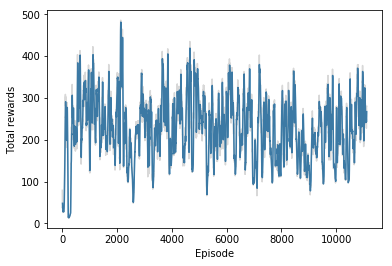

In [20]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

In [ ]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    state = env.reset()
    total_reward = 0
    while True:
        env.render()
        action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                feed_dict = {model.states: state.reshape([1, -1]), 
                                                             model.initial_state: initial_state})
        action = np.argmax(action_logits)
        state, reward, done, _ = env.step(action)
        total_reward += reward
        if done:
            break
print('total_reward:{}'.format(total_reward))
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.